<a href="https://colab.research.google.com/github/dkalenov/Bicycle-Sharing-Prediction-Models/blob/main/Bicycle_sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Data](https://raw.githubusercontent.com/dkalenov/Bicycle-Sharing-Prediction-Models/main/seoul_bike_data.csv) of a bicycle rental service in Korea over the year.

Data description:
- Date - date(DD/MM/YYYY);
- Rented Bike Count - how many bicycles were rented, target variable;
- Hour - hour of the day (24 time zone);
- Temperature - air temperature in degrees Celsius;
- Humidity - air humidity;
- Wind Speed - wind speed in m/s;
- Visibility - a measure of the visibility of objects at a distance of 10 meters;
- Dew point temperature - temperature recorded at the beginning of the day, in degrees Celsius;
- Solar Radiation - intensity of sunlight;
- Rainfall - amount of precipitation in mm;
- Snowfall - amount of snow fallen in mm;
- Seasons - time of year;
- Holiday - whether the day is a holiday;
- Functioning Day - marker whether the rental service was working at the specified time.

Goal of the work: study data and identify factors influencing the demand for bicycles.

Tasks:
1.  Pre-process the data: check the data for outliers, erroneous values, omissions, duplicates and incorrect types.
2. Conduct EDA: implement all levels of analysis (univariate/multidimensional) using visualizations, study the distributions and relationships of features.
3. Prepare data for building a model (feature coding, scaling, splitting the sample into training and testing).
4. Implement a basic regression model for predicting the number of bicycles rented.
5. Using the Feature Selection tools and hyperparameter selection, select the best predictive model based on adjusted R2 (main metric) and RMSE.Achieve adjusted R2 of at least 89%.

# Data preprocessing & EDA

## Functions for data processing and EDA

In [1]:
# Function for displaying basic information about the dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def basic_data_preprocessing(dataframe):
    # Convert all column titles to lowercase with "_" between words
    dataframe.columns = [x.lower().replace(' ', '_') for x in dataframe.columns.values]

    # Basic information about the dataset
    rows_num, columns_num = dataframe.shape
    print(f'Number of records: {rows_num}')
    print(f'Number of columns: {columns_num}\n')
    print('-' * 75)

    # Dataset information
    print("\nDataset Information:")
    display(dataframe.info())
    print()
    print('-' * 75)

    # Checking for missing values
    missing_values = dataframe.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values:")
        display(pd.DataFrame(missing_values, columns=['Missing Count']))
        display(dataframe[dataframe.isna().any(axis=1)])
    else:
        print("No missing values.")
    print('-' * 75)

    # Checking for zero-filled columns
    zero_columns = dataframe.columns[(dataframe == 0.0).any()]
    zero_count = dataframe[zero_columns].apply(lambda x: x.value_counts().get(0, 0))
    if zero_count.sum() != 0:
        print('Rows with value 0 found:')
        display(pd.DataFrame(zero_count, columns=['Zero Count']))
    else:
        print('No rows with value 0.')
    print('-' * 75)

    # Checking for duplicates
    if dataframe.duplicated().sum() > 0:
        print("Duplicate data found. Number of duplicates:", dataframe.duplicated().sum())
        display(dataframe[dataframe.duplicated(keep=False)])
    else:
        print("No duplicates found.")
    print('-' * 75)

    # Checking for negative values in the dataframe
    # Excluding columns with string data type (object type)
    dataframe_digits = dataframe.select_dtypes(exclude=['object'])
    if (dataframe_digits < 0).sum().sum() > 0:
        print("Negative values found:")
        display(pd.DataFrame((dataframe_digits < 0).sum(), columns=['Negative Value Count']))
    else:
        print('No negative values found.')
    print('-' * 75)

    # Statistical description of the data
    print("\nStatistical Description of the Data:\n")
    display(dataframe.describe())
    print('-' * 75)

    # Data Distribution
    print("\nData Distribution:")

    # Determine the number of graphs and rows for the subplots
    num_graphs = len(dataframe.columns)
    num_rows = (num_graphs + 1) // 2
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 4))

    for i, column in enumerate(dataframe.columns):
        ax = axes[i // 2, i % 2]  # Get the current axis from the subplot grid

        # Categorical feature: countplot
        if dataframe[column].dtype == 'object':
            sns.countplot(data=dataframe, x=column, ax=ax, color='dodgerblue')
            ax.tick_params(axis='x')
            total = float(len(dataframe[column]))
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

        # Numeric feature with less than 8 unique values: countplot
        else:
            if len(dataframe[column].unique()) < 8:
                sns.countplot(data=dataframe, x=column, ax=ax, color='dodgerblue')
                ax.tick_params(axis='x')
                total = float(len(dataframe[column]))
                for p in ax.patches:
                    height = p.get_height()
                    ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
            else:
                sns.histplot(data=dataframe, x=column, kde=True, ax=ax, color='dodgerblue')
                ax.axvline(dataframe[column].mean(), color='red', linestyle='--')
        # Set visualization properties for the current axis
        ax.grid(False)
        ax.set_title(column)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_facecolor('white')
        ax.tick_params(top=False, bottom=False, left=False, right=False)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

In [2]:
# Function for compression of the data type of columns in a pandas DataFrame

import pandas as pd
import numpy as np

def data_type_compression(dataframe):

    for column in dataframe.columns:
        unique_values = dataframe[column].unique()

        # Check if the column has two unique values (potentially a boolean column)
        # Uncomment the code below if you want to convert such columns to boolean type
        # if len(unique_values) == 2:
        #   dataframe[column] = dataframe[column].astype(bool)

        # Check if the column has an integer data type
        if dataframe[column].dtype == int:
            max_value = np.max(dataframe[column])

            # Assign the appropriate integer type based on the maximum value in the column
            if max_value <= np.iinfo(np.int8).max:
                dataframe[column] = dataframe[column].astype(np.int8)
            elif max_value <= np.iinfo(np.int16).max:
                dataframe[column] = dataframe[column].astype(np.int16)
            elif max_value <= np.iinfo(np.int32).max:
                dataframe[column] = dataframe[column].astype(np.int32)
            else:
                dataframe[column] = dataframe[column].astype(np.int64)

        # Check if the column has a float data type
        elif dataframe[column].dtype == float:
            max_value = np.max(dataframe[column])

            # Assign the appropriate float type based on the maximum value in the column
            if max_value <= np.finfo(np.float16).max:
                dataframe[column] = dataframe[column].astype(np.float16)
            elif max_value <= np.finfo(np.float32).max:
                dataframe[column] = dataframe[column].astype(np.float32)
            else:
                dataframe[column] = dataframe[column].astype(np.float64)

In [3]:
# Function for visualizing the distribution of different features by a target feature

import matplotlib.pyplot as plt
import seaborn as sns

def data_distribution_by_target(dataframe, target_feature):
    for column in dataframe.columns:
        if column != target_feature:
            # Create a new figure with size (8, 6)
            plt.figure(figsize=(8, 6))

            # Set style for grid (white with no grid lines)
            sns.set_style("whitegrid", {'axes.grid': False})

            # Categorical feature: barplot
            if dataframe[column].dtype == 'object':
                #plt.xticks(rotation=45, ha='right')
                plot = sns.barplot(x=column, y=target_feature, data=dataframe)

            # Date/time feature: lineplot
            elif dataframe[column].dtype == 'datetime64[ns]':
                plt.xticks(rotation=45, ha='right')
                plot = sns.lineplot(x=column, y=target_feature, data=dataframe)

            # Boolean feature: barplot
            elif dataframe[column].dtype == 'bool':
                plt.xticks([0, 1], ['False', 'True'])
                #plt.xticks(rotation=45, ha='right')
                plot = sns.barplot(x=column, y=target_feature, data=dataframe)

            # Numeric feature: histogram with kernel density estimation (kde)
            elif dataframe[column].dtype in ['float64', 'float32', 'float16']:
                # Determine the number of bins for the histogram
                n_bins = min(30, len(dataframe[column].unique()))
                # Calculate the bin width and range
                binwidth = (dataframe[column].max() - dataframe[column].min()) / n_bins
                binrange = (dataframe[column].min(), dataframe[column].max())
                # Create a histogram with KDE
                sns.histplot(data=dataframe, x=column, bins=n_bins, binwidth=binwidth, binrange=binrange, kde=True, cumulative=False)
                plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)   # Add a vertical line at the mean value
                #plt.xticks(rotation=45, ha='right')

            # Other feature types: scatterplot with regression line or countplot
            else:
                if dataframe[column].nunique() > 6:
                    # Create a scatterplot with regression line
                    plot = sns.scatterplot(data=dataframe, x=column, y=target_feature, alpha=0.7)
                    sns.regplot(data=dataframe, x=column, y=target_feature, scatter=False, lowess=True, line_kws={"color": "C1"})
                    # plt.xticks(rotation=45, ha='right')
                    plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)
                else:
                    # Create a countplot
                    plot = sns.countplot(data=dataframe, x=column, y=target_feature)

            plot.set_title(f'Data Distribution by {target_feature}: {column}')  # Set title
            plot.set_xlabel(column)  # Set x-axis label
            plot.set_ylabel(target_feature)  # Set y-axis label
            plt.tight_layout() # Adjust plot layout
            plt.show()

In [4]:
# Function for detecting outliers in a dataframe
# Displays boxplots and a table with outlier information

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def detect_outliers(dataframe):
    outlier_table = pd.DataFrame(columns=['Column', 'Outlier Count', 'Outlier Percentage'])  # Creating a DataFrame to store outlier information

    for column in dataframe.columns:
        if dataframe[column].dtype != 'object' and len(dataframe[column].unique()) == 2:  # Checking for columns with binary values
            print(f"No outliers in column '{column}' as it has binary values.")  # Printing a message indicating binary values
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': ['NaN'],
                                       'Outlier Percentage': ['NaN']})],
                                       ignore_index=True)  # Updating the outlier table with binary value information
            print('*' * 75)
            print()
            continue  # Skipping to the next iteration if the column has binary values

        q1 = dataframe[column].quantile(0.25)  # Calculating the first quartile
        q3 = dataframe[column].quantile(0.75)  # Calculating the third quartile
        iqr = q3 - q1  # Calculating the interquartile range
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Counting the number of outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        num_outliers = len(outliers)
        column_len = len(dataframe[column])

        if num_outliers == 0:
            print(f"No outliers in column '{column}'.")
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                                    'Outlier Count': [0],
                                                    'Outlier Percentage': [0]})],
                                                    ignore_index=True)  # Updating the outlier table with outlier count
        else:
            print(f"Outliers in column '{column}':")
            print(f"Outlier Count: {num_outliers}")
            print(f"Outlier Percentage of total observations: {(num_outliers / column_len) * 100:.2f}%")  # Calculating and displaying outlier percentage
            print("Outlier Values:", ", ".join(outliers[column].astype(str)))

            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': [num_outliers],
                                       'Outlier Percentage': [(num_outliers / column_len) * 100]})],
                                       ignore_index=True)  # Updating the outlier table with outlier information

            # Plotting the boxplot with outliers
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.boxplot(data=dataframe, x=column, ax=ax)
            ax.set_title(f"Outlier Plot for column '{column}'")
            plt.show()

        print('*' * 75)
        print()

    display(outlier_table)

In [5]:
# Correlation analysis on a dataframe with a target feature using some specified correlation types

!pip install phik
from phik import phik_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def correlation_analysis(dataframe, target_feature, correlation_types=['phik'], apply_abs=False):
    target_column = dataframe[target_feature] # Target feature
    correlation_data = [] # List to store correlations
    interval_cols = [col for col in dataframe.columns if col != target_feature] # Set interval columns for phik

    # Calculate correlation coefficients with the target feature for each column and specified correlation types
    for column in dataframe.columns:
        if column != target_feature:
            for corr_type in correlation_types:
                corr_value = None

                if corr_type == 'pearson':
                    corr_value = stats.pearsonr(target_column, dataframe[column])[0]
                elif corr_type == 'spearman':
                    corr_value = stats.spearmanr(target_column, dataframe[column]).correlation
                elif corr_type == 'kendall':
                    corr_value = stats.kendalltau(target_column, dataframe[column]).correlation
                elif corr_type == 'phik':
                    corr_value = phik_matrix(dataframe, interval_cols=interval_cols)[target_feature][column]
                # Apply absolute value, if specified
                if corr_value is not None and apply_abs:
                  corr_value = abs(corr_value)
                correlation_data.append((column, corr_type, corr_value))

    correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation Type', 'Correlation Value'])  # Create DataFrame
    correlation_df_sorted = correlation_df.pivot(index='Column', columns='Correlation Type', values='Correlation Value')
    correlation_df_sorted = correlation_df_sorted[correlation_types] # Keep only specified correlation types
    correlation_df_sorted = correlation_df_sorted.sort_values(by=correlation_types, ascending=False) # Sort the data by specified correlation types


    # Correlation plot
    fig, axes = plt.subplots(nrows=1, ncols=len(correlation_types), figsize=(8 * len(correlation_types), 6))

    for i, corr_type in enumerate(correlation_types):
        corr_with_target = correlation_df_sorted[corr_type]
        corr_with_target_sorted = corr_with_target.sort_values(ascending=True) # Sort the data

        # Set plot parameters
        sns.barplot(data=corr_with_target_sorted.reset_index(), x='Column', y=corr_type, ax=axes[i], color='dodgerblue')


        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(corr_type)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
    plt.tight_layout(pad=1)
    plt.show()


    # Top 2 features with the highest correlation for each specified correlation type
    top_columns = {}
    for corr_type in correlation_types:
        sorted_columns = correlation_df_sorted[corr_type].abs().sort_values(ascending=False)
        top_columns[corr_type] = sorted_columns.index[:2].tolist()

    # Display correlation table
    print(f"Correlation table with target feature '{target_feature}':")
    display(correlation_df_sorted)

    # Display the top 2 features with the highest correlation for each correlation type
    for corr_type in correlation_types:
        print()
        print(f"Top 2 features with highest correlation ({corr_type.capitalize()}):", top_columns[corr_type])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 5.3 MB/s eta 0:00:00


In [6]:
# Function to find multicollinearity and print correlation matrix

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix

def find_multicollinearity(dataframe, methods=['phik'], threshold=0.8):
    # List to store all multicollinear tables
    multicollinear_tables = []

    # Iterate through each method in the list of methods
    for method in methods:
        # Convert method to lowercase
        method = method.lower()

        # Calculate correlation matrix using specified sort method
        if method in ['pearson', 'kendall', 'spearman']:
            corr_matrix = dataframe.corr(method=method).abs()
        elif method == 'phik':
            interval_cols = [col for col in dataframe.columns]
            corr_matrix = phik_matrix(dataframe, interval_cols=interval_cols)
        else:
            print(f"Invalid method: {method}")
            continue

        # Exclude correlation of a variable with itself
        np.fill_diagonal(corr_matrix.values, np.NaN)

        # Create a larger figure size based on the number of features
        n = corr_matrix.shape[0]
        fig_width = 6 + n * 0.5
        fig_height = 4 + n * 0.3

        # Plot correlation matrix as heatmap with adjusted figure size
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", mask=np.isnan(corr_matrix))
        plt.title(f"Correlation Matrix ({method})")
        plt.show()

        # Initialize an empty list to store multicollinear features
        multicollinear_table = []

        # Iterate through each pair of multicollinear features and their correlation percentages
        for i in range(n):
            for j in range(i+1, n):
                # Check if the correlation between the two features is above the threshold
                if corr_matrix.iloc[i, j] > threshold:
                    feature1 = corr_matrix.columns[i]
                    feature2 = corr_matrix.columns[j]
                    # Append the pair of multicollinear features and their correlation percentage to the list
                    multicollinear_table.append({'Feature 1': feature1, 'Feature 2': feature2, 'Correlation': corr_matrix.iloc[i, j]})

        # Create a dataframe from the list of multicollinear features
        multicollinear_table = pd.DataFrame(multicollinear_table)

        if not multicollinear_table.empty:
            # Sort the multicollinear table by correlation in descending order
            multicollinear_table = multicollinear_table.sort_values(by='Correlation', ascending=False)
            # Append the multicollinear table to the list of multicollinear tables
            multicollinear_tables.append((method, multicollinear_table))

    # Print all multicollinear tables
    if multicollinear_tables:
        for method, table in multicollinear_tables:
            print(f"\nMulticollinearity Table ({method})")
            display(table)
    else:
        print("\nNo features with high multicollinearity!")

## Data processing

In [7]:
import pandas as pd

url = 'https://raw.githubusercontent.com/dkalenov/Bicycle-Sharing-Prediction-Models/main/seoul_bike_data.csv'
data = pd.read_csv(url, encoding='latin1')
data.head()

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

Number of records: 8760
Number of columns: 14

---------------------------------------------------------------------------

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       8760 non-null   object 
 1   rented_bike_count          8760 non-null   int64  
 2   hour                       8760 non-null   int64  
 3   temperature(°c)            8760 non-null   float64
 4   humidity(%)                8760 non-null   int64  
 5   wind_speed_(m/s)           8760 non-null   float64
 6   visibility_(10m)           8760 non-null   int64  
 7   dew_point_temperature(°c)  8760 non-null   float64
 8   solar_radiation_(mj/m2)    8760 non-null   float64
 9   rainfall(mm)               8760 non-null   float64
 10  snowfall_(cm)              8760 non-null   float64
 11  seasons        

None


---------------------------------------------------------------------------
No missing values.
---------------------------------------------------------------------------
Rows with value 0 found:


Zero Count
rented_bike_count                 295
hour                              365
temperature(°c)                    21
humidity(%)                        17
wind_speed_(m/s)                   74
dew_point_temperature(°c)          60
solar_radiation_(mj/m2)          4300
rainfall(mm)                     8232
snowfall_(cm)                    8317

---------------------------------------------------------------------------
No duplicates found.
---------------------------------------------------------------------------
Negative values found:


Negative Value Count
rented_bike_count                             0
hour                                          0
temperature(°c)                            1433
humidity(%)                                   0
wind_speed_(m/s)                              0
visibility_(10m)                              0
dew_point_temperature(°c)                  3138
solar_radiation_(mj/m2)                       0
rainfall(mm)                                  0
snowfall_(cm)                                 0

---------------------------------------------------------------------------

Statistical Description of the Data:



rented_bike_count         hour  temperature(°c)  humidity(%)  \
count        8760.000000  8760.000000      8760.000000  8760.000000   
mean          704.602055    11.500000        12.882922    58.226256   
std           644.997468     6.922582        11.944825    20.362413   
min             0.000000     0.000000       -17.800000     0.000000   
25%           191.000000     5.750000         3.500000    42.000000   
50%           504.500000    11.500000        13.700000    57.000000   
75%          1065.250000    17.250000        22.500000    74.000000   
max          3556.000000    23.000000        39.400000    98.000000   

       wind_speed_(m/s)  visibility_(10m)  dew_point_temperature(°c)  \
count       8760.000000       8760.000000                8760.000000   
mean           1.724909       1436.825799                   4.073813   
std            1.036300        608.298712                  13.060369   
min            0.000000         27.000000                 -30.600000   
25%            0.900000        940.000000                  -4.700000   
50%            1.500000       1698.000000                   5.100000   
75%            2.300000       2000.000000                  14.800000   
max            7.400000       2000.000000                  27.200000   

       solar_radiation_(mj/m2)  rainfall(mm)  snowfall_(cm)  
count              8760.000000   8760.000000    8760.000000  
mean                  0.569111      0.148687       0.075068  
std                   0.868746      1.128193       0.436746  
min                   0.000000      0.000000       0.000000  
25%                   0.000000      0.000000       0.000000  
50%                   0.010000      0.000000       0.000000  
75%                   0.930000      0.000000       0.000000  
max                   3.520000     35.000000       8.800000

---------------------------------------------------------------------------

Data Distribution:


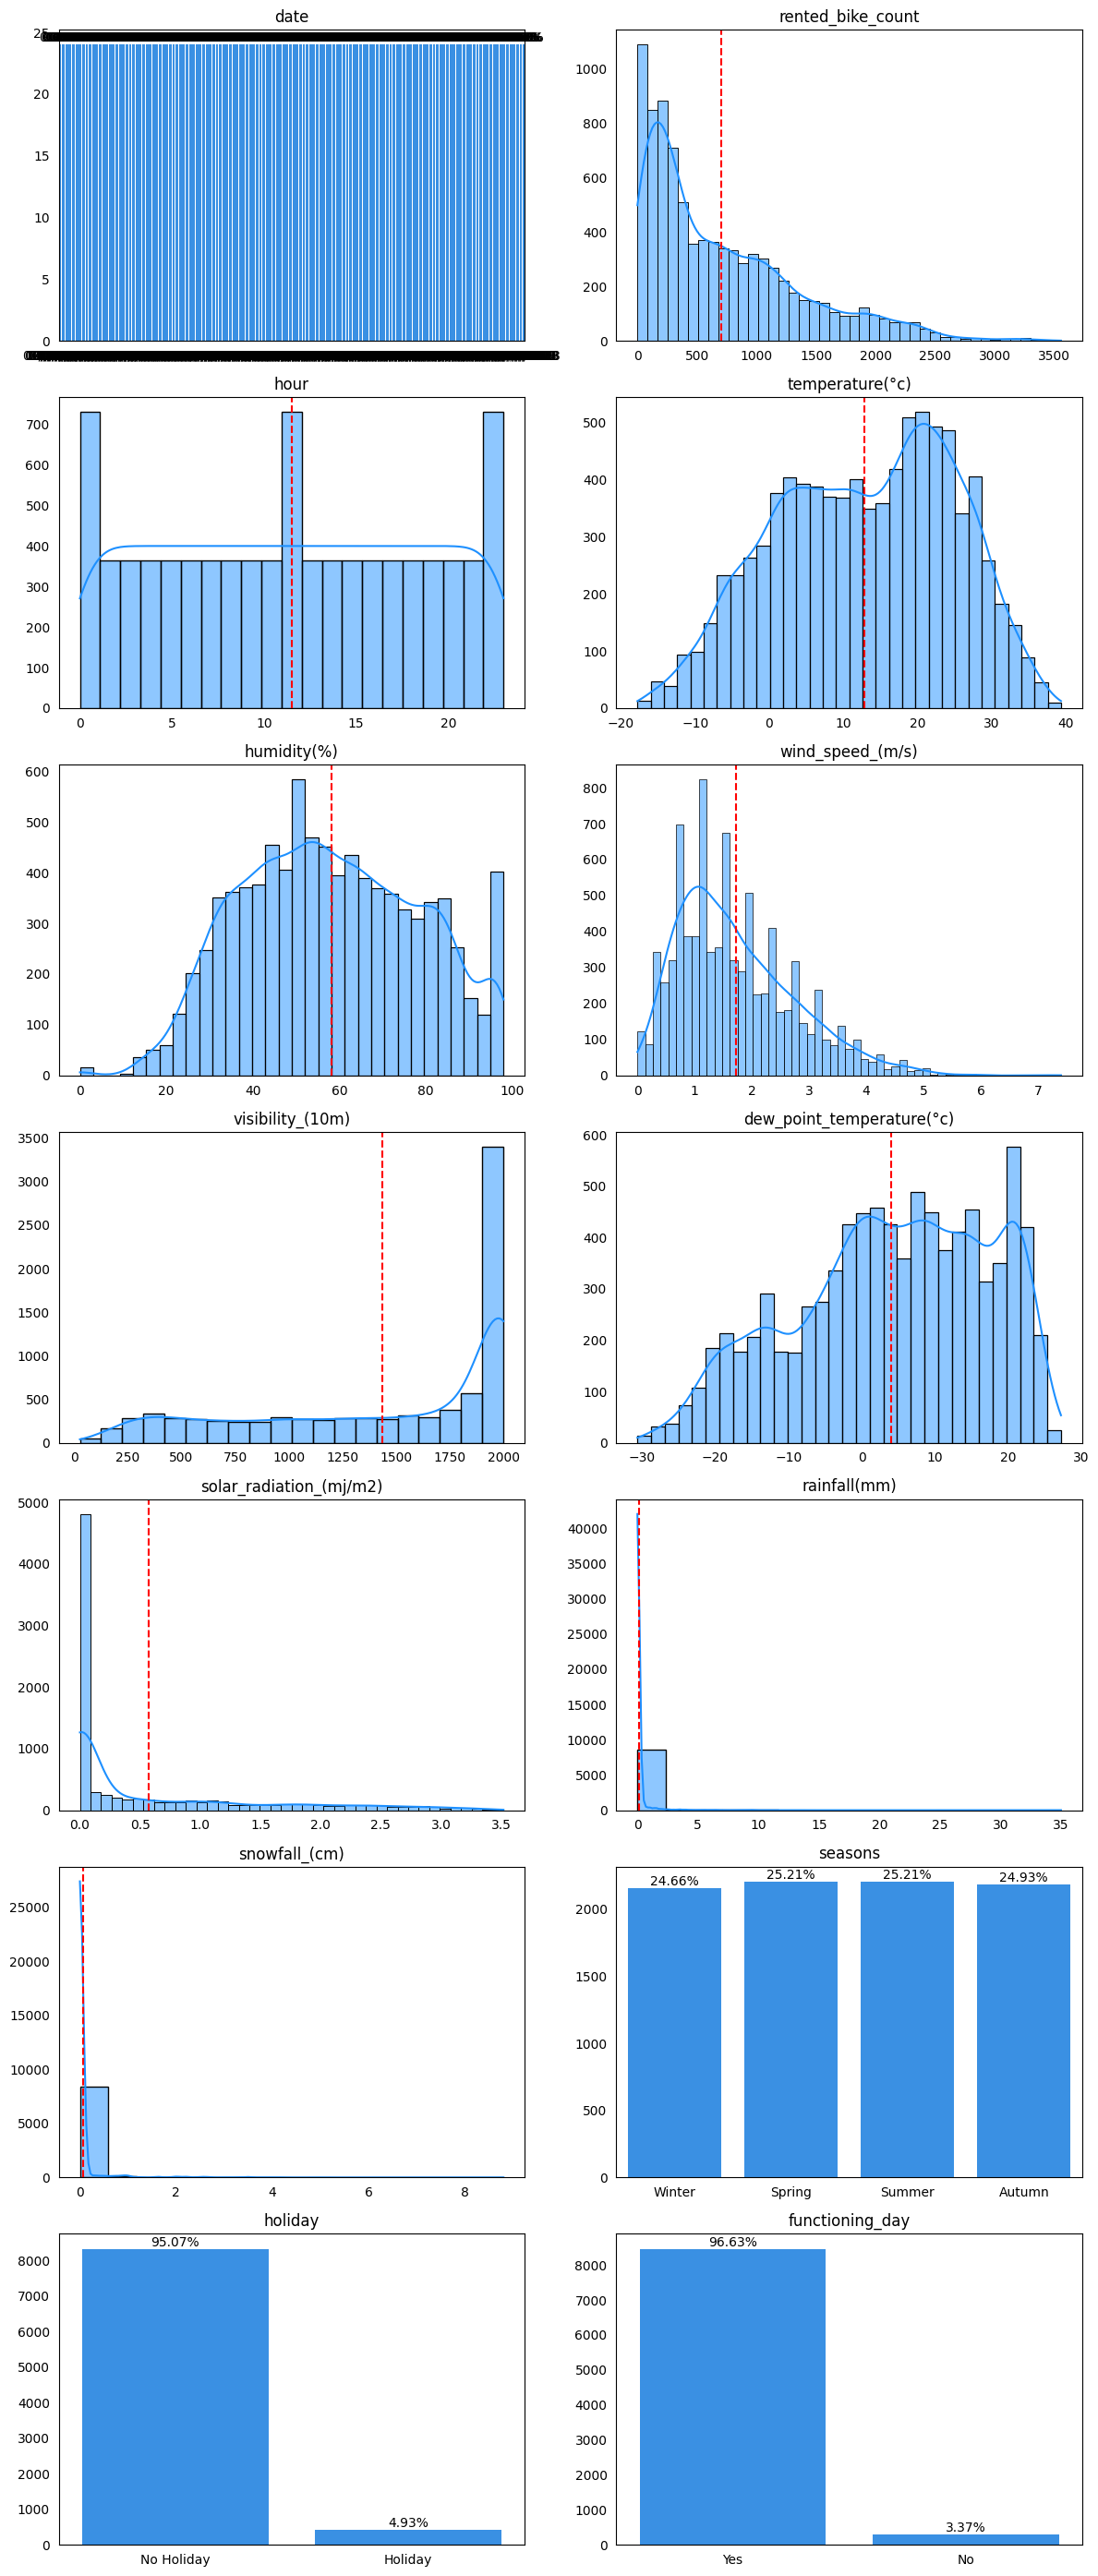

In [8]:
# Basic information about the dataset
basic_data_preprocessing(data)

* All numerical data ('rented_bike_count', 'temperature(°c)', 'humidity(%)',
  'wind_speed_(m/s)', 'visibility_(10m)', 'dew_point_temperature(°c)', 'solar_radiation_(mj/m2)', 'rainfall(mm)', 'snowfall_(cm)') are not normally distributed. It is likely that scaling the data will increase the strength of the models;
* All categorical data, except 'holiday', are normally distributed in some proportion. The 'holiday' column greatly (hundreds of times) increases the number of non-working days compared to non-working days.

In [9]:
# make a copy of the dataframe
df = data.copy()

In [10]:
# compress int and float data
data_type_compression(df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       8760 non-null   object 
 1   rented_bike_count          8760 non-null   int16  
 2   hour                       8760 non-null   int8   
 3   temperature(°c)            8760 non-null   float16
 4   humidity(%)                8760 non-null   int8   
 5   wind_speed_(m/s)           8760 non-null   float16
 6   visibility_(10m)           8760 non-null   int16  
 7   dew_point_temperature(°c)  8760 non-null   float16
 8   solar_radiation_(mj/m2)    8760 non-null   float16
 9   rainfall(mm)               8760 non-null   float16
 10  snowfall_(cm)              8760 non-null   float16
 11  seasons                    8760 non-null   object 
 12  holiday                    8760 non-null   object 
 13  functioning_day            8760 non-null   objec

In [12]:
# Convert the data type for the 'date' column
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

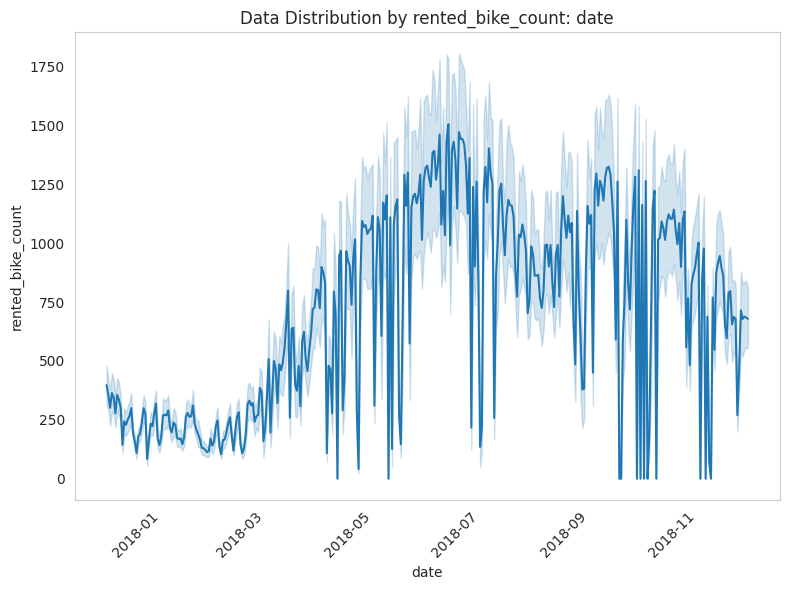

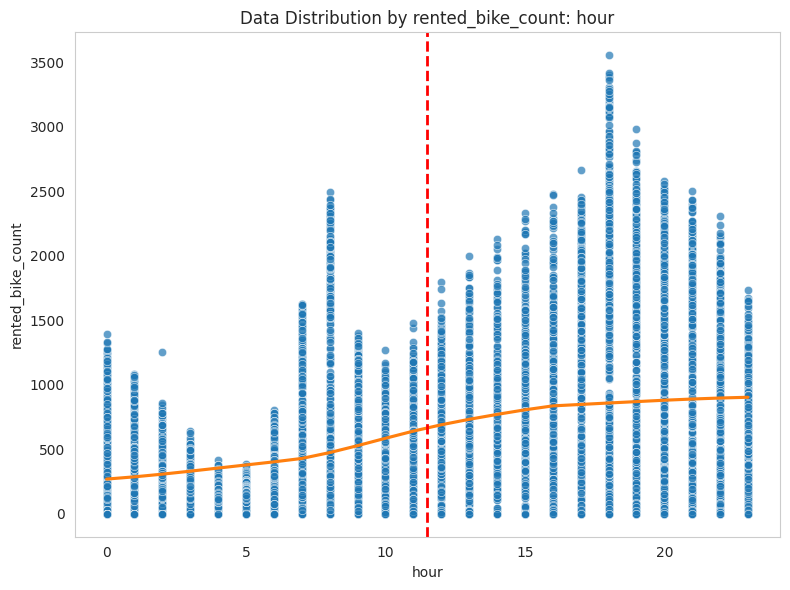

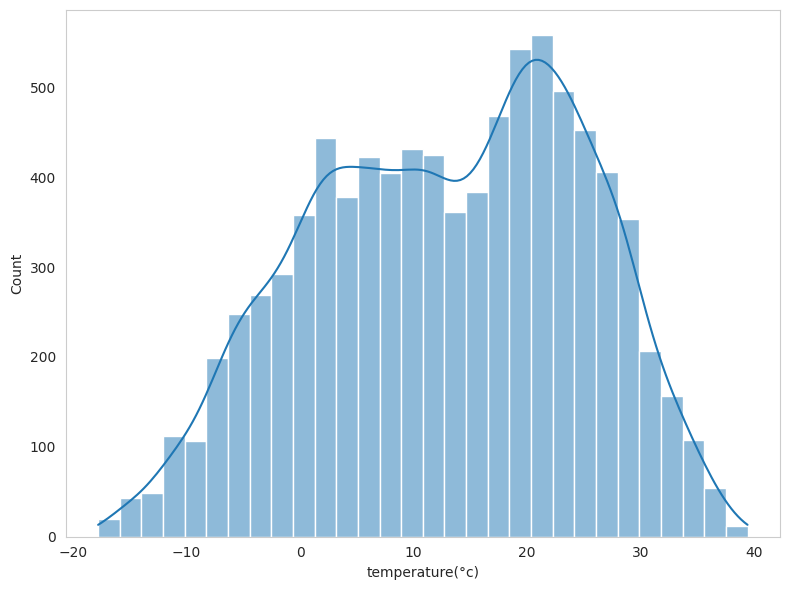

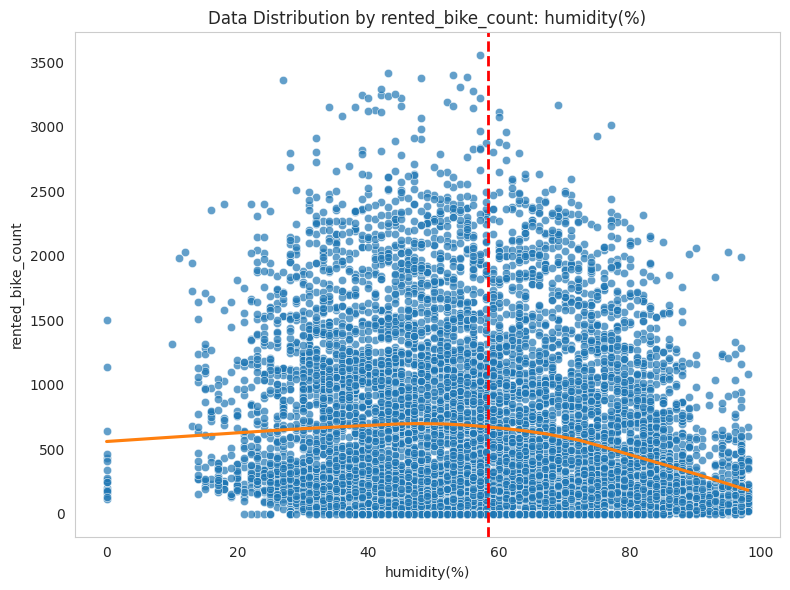

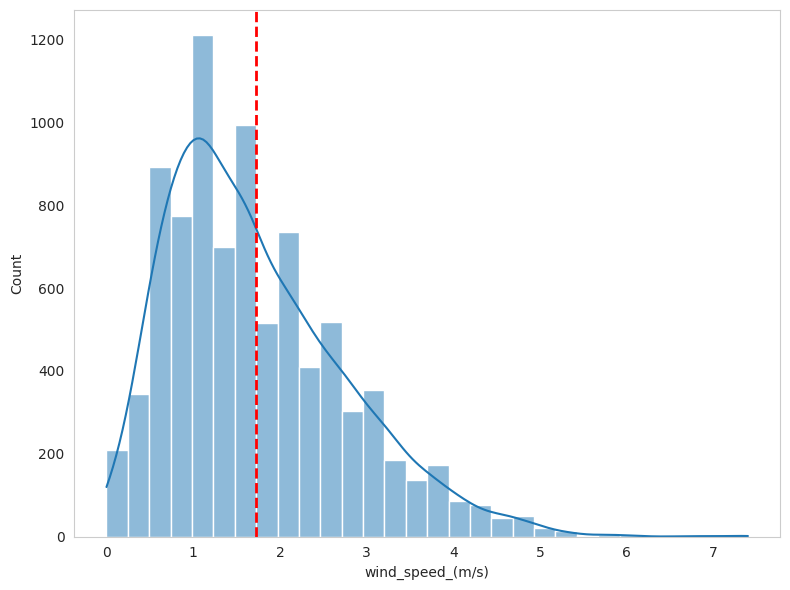

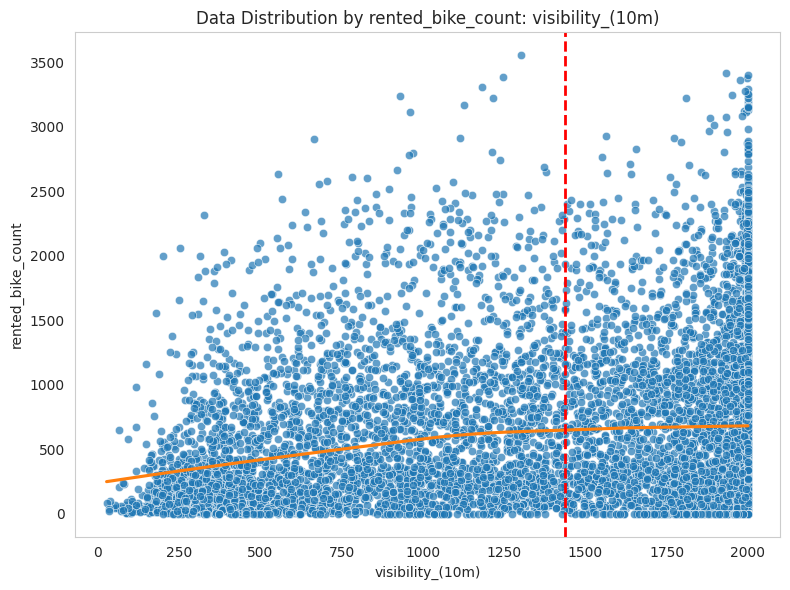

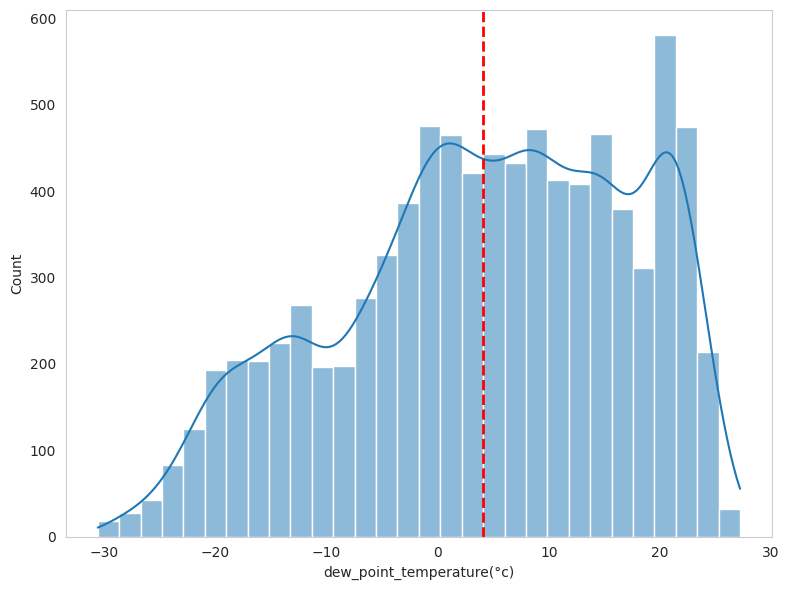

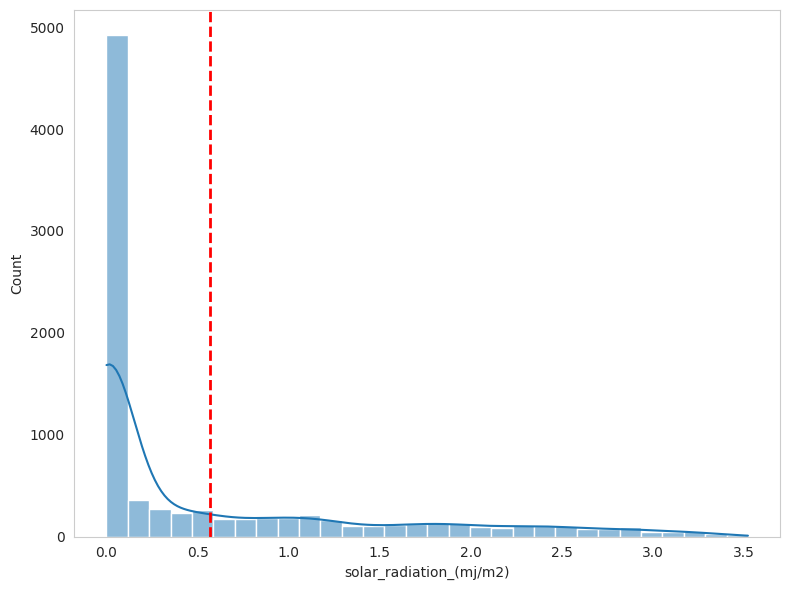

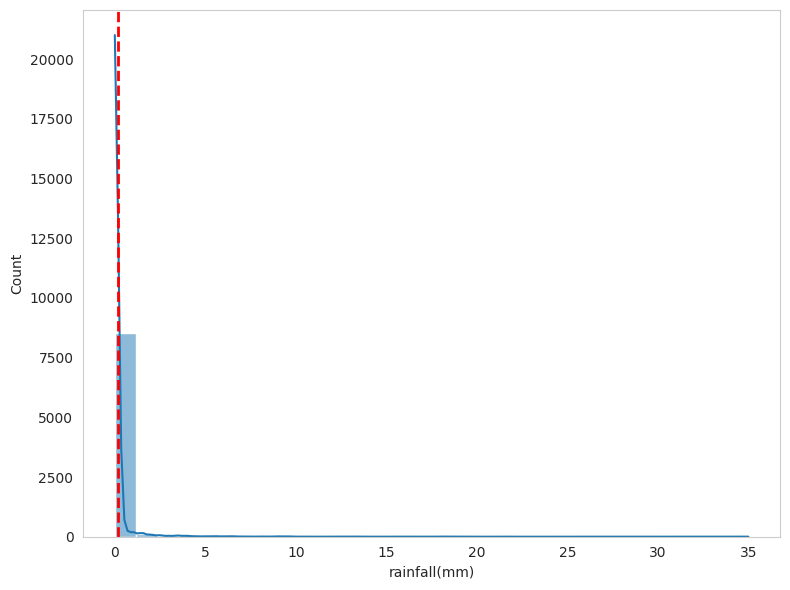

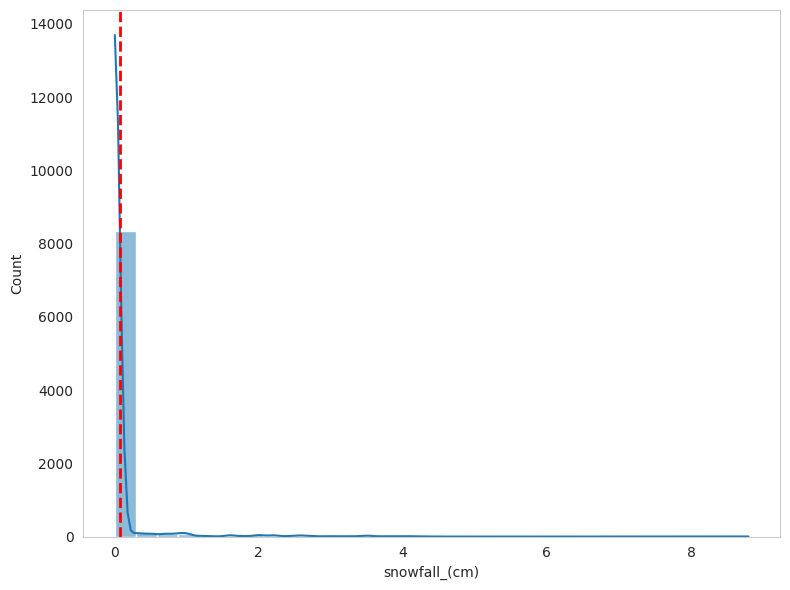

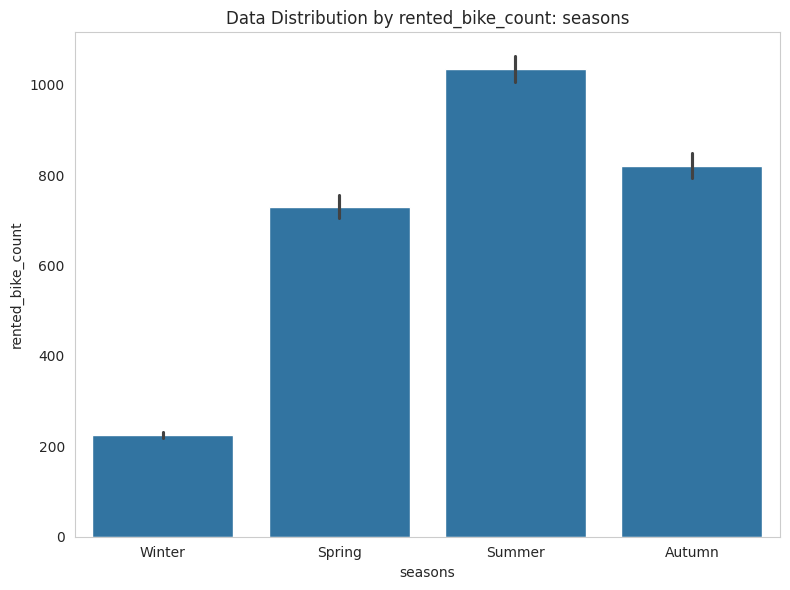

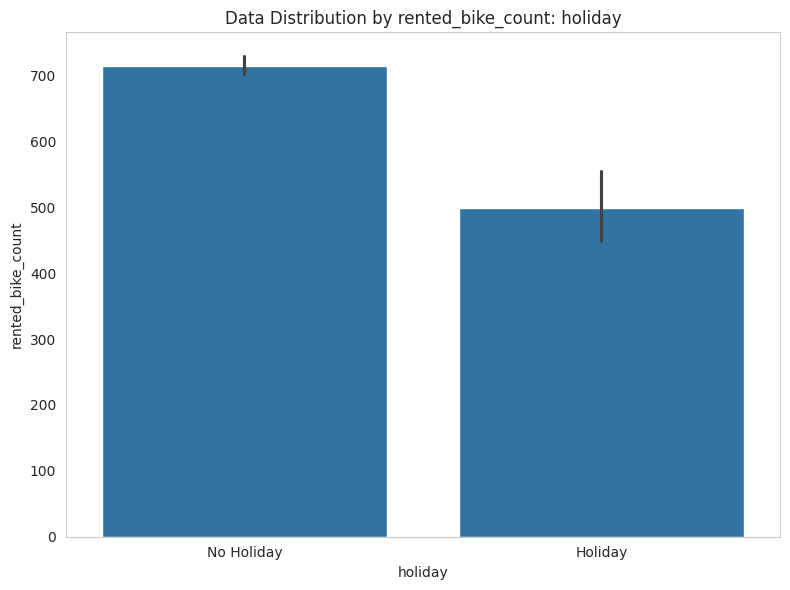

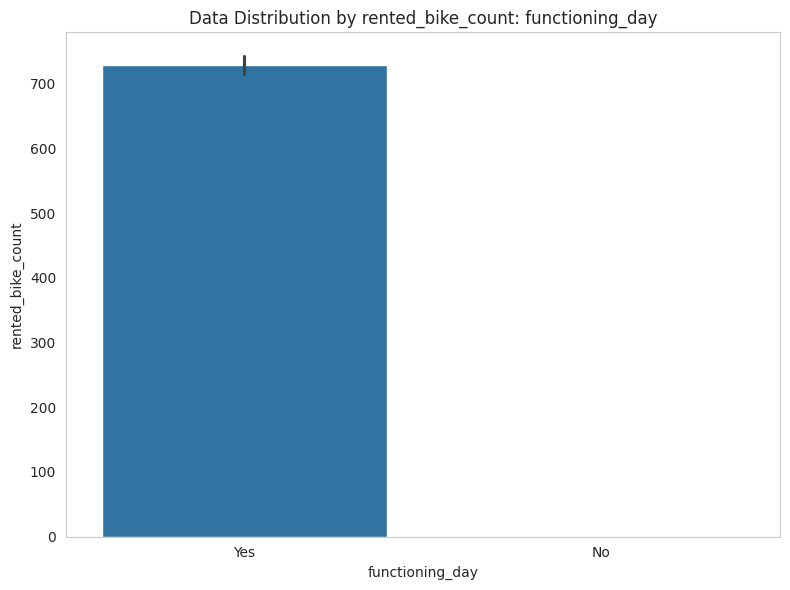

In [13]:
# dynamics of the target feature by other features
data_distribution_by_target(df, 'rented_bike_count')

In [14]:
# Make sure that there are no rented bikes on non-functioning days
df_filtered = df[(df['functioning_day'] == 'No') & (df['rented_bike_count'] > 0)]
df_filtered

Empty DataFrame
Columns: [date, rented_bike_count, hour, temperature(°c), humidity(%), wind_speed_(m/s), visibility_(10m), dew_point_temperature(°c), solar_radiation_(mj/m2), rainfall(mm), snowfall_(cm), seasons, holiday, functioning_day]
Index: []

Let's remove rows when the service was not working and then remove the 'functioning_day' column, since no bikes were rented on those days.

In [15]:
# Remove rows in which the value of the target parameter is 0
df = df[df['functioning_day'] != 'No']

In [16]:
# Remove the 'functioning_day' column
df = df.drop('functioning_day', axis=1)

In [17]:
# Check if there are still zero values in rented_bike_count
zero_count_df = df[df['rented_bike_count'] == 0]
zero_count_df

Empty DataFrame
Columns: [date, rented_bike_count, hour, temperature(°c), humidity(%), wind_speed_(m/s), visibility_(10m), dew_point_temperature(°c), solar_radiation_(mj/m2), rainfall(mm), snowfall_(cm), seasons, holiday]
Index: []

Let's try to group 'hour' by parts of the day: 'night' (from 0 to 6), 'morning' (from 6 to 12), 'aftenoon' (from 12 to 18), 'evening' (from 18 to 24). So, in theory, this can help to better summarize the data.

In [18]:
df.columns.tolist()

['date',
 'rented_bike_count',
 'hour',
 'temperature(°c)',
 'humidity(%)',
 'wind_speed_(m/s)',
 'visibility_(10m)',
 'dew_point_temperature(°c)',
 'solar_radiation_(mj/m2)',
 'rainfall(mm)',
 'snowfall_(cm)',
 'seasons',
 'holiday']

In [19]:
# Let's make a copy to compare later whether grouping by hour will have a positive effect
df_grouped = df.copy()

In [20]:
# create a new column 'time_group'
df_grouped['time_group'] = pd.cut(df_grouped['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)

In [21]:
# remove the 'hour' column
df_grouped = df_grouped.drop('hour', axis=1)

In [22]:
df_grouped.head(3)

date  rented_bike_count  temperature(°c)  humidity(%)  \
0 2017-12-01                254        -5.199219           37   
1 2017-12-01                204        -5.500000           38   
2 2017-12-01                173        -6.000000           39   

   wind_speed_(m/s)  visibility_(10m)  dew_point_temperature(°c)  \
0          2.199219              2000                 -17.593750   
1          0.799805              2000                 -17.593750   
2          1.000000              2000                 -17.703125   

   solar_radiation_(mj/m2)  rainfall(mm)  snowfall_(cm) seasons     holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   

  time_group  
0      night  
1      night  
2      night

Преобразуем даты в дни недели, чтобы исключить уникальные значения из датафреймов и лучше обобщить данные

In [23]:
# Convert dates to days of the week in both dataframes
df['date'] = pd.to_datetime(df['date']).dt.day_name()
df_grouped['date'] = pd.to_datetime(df_grouped['date']).dt.day_name()

In [24]:
# Encode categorical features in both dataframes
df = pd.get_dummies(df, columns=['date', 'seasons', 'holiday'], drop_first=True)
df_grouped = pd.get_dummies(df_grouped, columns=['date', 'time_group', 'seasons', 'holiday'], drop_first=True)

In [25]:
df.head(1)

rented_bike_count  hour  temperature(°c)  humidity(%)  wind_speed_(m/s)  \
0                254     0        -5.199219           37          2.199219   

   visibility_(10m)  dew_point_temperature(°c)  solar_radiation_(mj/m2)  \
0              2000                  -17.59375                      0.0   

   rainfall(mm)  snowfall_(cm)  date_Monday  date_Saturday  date_Sunday  \
0           0.0            0.0            0              0            0   

   date_Thursday  date_Tuesday  date_Wednesday  seasons_Spring  \
0              0             0               0               0   

   seasons_Summer  seasons_Winter  holiday_No Holiday  
0               0               1                   1

In [26]:
df_grouped.head(1)

rented_bike_count  temperature(°c)  humidity(%)  wind_speed_(m/s)  \
0                254        -5.199219           37          2.199219   

   visibility_(10m)  dew_point_temperature(°c)  solar_radiation_(mj/m2)  \
0              2000                  -17.59375                      0.0   

   rainfall(mm)  snowfall_(cm)  date_Monday  ...  date_Thursday  date_Tuesday  \
0           0.0            0.0            0  ...              0             0   

   date_Wednesday  time_group_morning  time_group_afternoon  \
0               0                   0                     0   

   time_group_evening  seasons_Spring  seasons_Summer  seasons_Winter  \
0                   0               0               0               1   

   holiday_No Holiday  
0                   1  

[1 rows x 22 columns]

In [27]:
# df colunms renaming

# Replace values in 'Holiday_No Holiday' column
df['holiday_No Holiday'] = df['holiday_No Holiday'].replace({0: 1, 1: 0})

# Rename columns for convenience
df = df.rename(columns={'holiday_No Holiday': 'holiday',
                        'temperature(°c)': 'temperature',
                        'humidity(%)': 'humidity',
                        'wind_speed_(m/s)': 'wind_speed',
                        'visibility_(10m)': 'visibility',
                        'dew_point_temperature(°c)': 'dew_point_temperature',
                        'solar_radiation_(mj/m2)': 'solar_radiation',
                        'rainfall(mm)': 'rainfall',
                        'snowfall_(cm)': 'snowfall',
                        'date_Monday': 'monday',
                        'date_Saturday': 'saturday',
                        'date_Sunday': 'sunday',
                        'date_Thursday': 'thursday',
                        'date_Tuesday': 'tuesday',
                        'date_Wednesday': 'wednesday',
                        'seasons_Spring': 'spring',
                        'seasons_Summer': 'summer',
                        'seasons_Winter': 'winter'
                        })

In [28]:
df.head(2)

rented_bike_count  hour  temperature  humidity  wind_speed  visibility  \
0                254     0    -5.199219        37    2.199219        2000   
1                204     1    -5.500000        38    0.799805        2000   

   dew_point_temperature  solar_radiation  rainfall  snowfall  monday  \
0              -17.59375              0.0       0.0       0.0       0   
1              -17.59375              0.0       0.0       0.0       0   

   saturday  sunday  thursday  tuesday  wednesday  spring  summer  winter  \
0         0       0         0        0          0       0       0       1   
1         0       0         0        0          0       0       0       1   

   holiday  
0        0  
1        0

In [29]:
# df_grouped colunms renaming

# Replace values in 'Holiday_No Holiday' column
df_grouped['holiday_No Holiday'] = df_grouped['holiday_No Holiday'].replace({0: 1, 1: 0})

df_grouped = df_grouped.rename(columns={'temperature(°c)': 'temperature',
                                        'humidity(%)': 'humidity',
                                        'wind_speed_(m/s)': 'wind_speed',
                                        'visibility_(10m)': 'visibility',
                                        'dew_point_temperature(°c)': 'dew_point_temperature',
                                        'solar_radiation_(mj/m2)': 'solar_radiation',
                                        'rainfall(mm)': 'rainfall',
                                        'snowfall_(cm)': 'snowfall',
                                        'date_Monday': 'monday',
                                        'date_Saturday': 'saturday',
                                        'date_Sunday': 'sunday',
                                        'date_Thursday': 'thursday',
                                        'date_Tuesday': 'tuesday',
                                        'date_Wednesday': 'wednesday',
                                        'time_group_morning': 'morning',
                                        'time_group_afternoon': 'afternoon',
                                        'time_group_evening': 'evening',
                                        'seasons_Spring': 'spring',
                                        'seasons_Summer': 'summer',
                                        'seasons_Winter': 'winter',
                                        'holiday_No Holiday': 'holiday'
                                        })

In [30]:
df_grouped.head(2)

rented_bike_count  temperature  humidity  wind_speed  visibility  \
0                254    -5.199219        37    2.199219        2000   
1                204    -5.500000        38    0.799805        2000   

   dew_point_temperature  solar_radiation  rainfall  snowfall  monday  ...  \
0              -17.59375              0.0       0.0       0.0       0  ...   
1              -17.59375              0.0       0.0       0.0       0  ...   

   thursday  tuesday  wednesday  morning  afternoon  evening  spring  summer  \
0         0        0          0        0          0        0       0       0   
1         0        0          0        0          0        0       0       0   

   winter  holiday  
0       1        0  
1       1        0  

[2 rows x 22 columns]

In [31]:
# df.columns.tolist()

Brief summary:
* In the 'Date' column changed  data type from *object* to *datetime*. The column is subsequently converted to days of the week.
* Removed lines in which the value of the target parameter ('rented_bike_count') was equal to zero; on these days the service did not work ('functioning_day' == 'No'). The 'functioning_day' column has been removed;
* Made a duplicate of the working dataframe - df_grouped. In df_grouped, based on the 'hour' column, the day was divided into 4 periods: 'night'(from 0 to 6), 'morning'(from 6 to 12), 'afternoon'(from 12 to 18), 'evening'(from 18 to 24). Thus, in theory, this can help in better generalizing the data; in the future, we will compare the correlations in df and df_grouped and the metrics of the base models. Removed the 'hour' column in df_grouped;
* Renamed columns in both dataframes and brought them to uniformity.

## Outliers checking




Outliers in column 'rented_bike_count':
Outlier Count: 152
Outlier Percentage of total observations: 1.80%
Outlier Values: 2401, 2402, 2401, 2404, 2692, 2807, 2574, 2577, 2558, 2661, 2392, 3130, 2405, 2701, 2410, 2906, 2915, 2479, 2439, 2403, 3069, 2450, 3123, 2454, 2825, 2916, 3245, 2656, 3251, 2650, 3119, 2534, 3088, 2505, 2514, 2460, 3380, 2788, 2508, 3227, 2615, 2404, 3221, 2649, 3309, 2797, 2476, 2431, 2495, 3404, 2873, 2579, 2505, 2474, 2664, 2479, 2404, 2962, 2460, 2891, 2984, 2441, 2451, 2475, 2497, 2435, 2474, 2481, 2429, 2515, 2430, 3556, 2809, 2525, 2440, 3384, 2741, 2519, 3418, 2811, 2556, 2436, 3365, 2732, 2493, 3238, 2779, 2456, 3172, 2487, 3113, 2602, 2965, 2598, 2398, 3080, 2637, 2415, 2594, 3196, 2557, 2931, 3016, 2884, 2636, 2770, 2692, 2640, 2419, 2405, 2416, 2481, 2797, 2628, 2830, 2528, 2836, 3166, 2491, 3160, 2468, 2497, 3154, 3298, 2518, 3222, 2455, 2391, 3256, 2443, 3146, 2826, 3277, 2489, 3154, 2422, 2432, 2397, 2857, 2400, 2787, 2514, 2618, 2635, 2716, 2445, 2

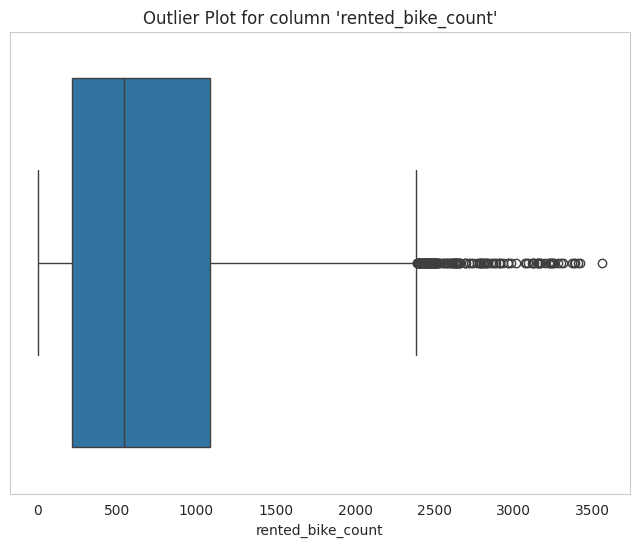

***************************************************************************

No outliers in column 'hour'.
***************************************************************************

No outliers in column 'temperature'.
***************************************************************************

No outliers in column 'humidity'.
***************************************************************************

Outliers in column 'wind_speed':
Outlier Count: 139
Outlier Percentage of total observations: 1.64%
Outlier Values: 4.5, 4.8, 5.4, 4.5, 5.8, 4.7, 5.3, 4.5, 4.5, 4.7, 5.1, 4.5, 4.6, 5.1, 4.5, 5.0, 4.9, 4.7, 5.0, 4.7, 4.5, 6.7, 4.6, 4.6, 5.0, 4.5, 4.6, 4.5, 4.5, 4.7, 5.3, 4.8, 4.5, 4.5, 4.6, 6.0, 4.7, 5.2, 4.6, 4.5, 4.5, 4.8, 4.6, 4.6, 4.8, 4.9, 4.7, 4.6, 4.5, 4.7, 4.5, 4.9, 5.0, 5.6, 5.1, 5.8, 4.5, 5.3, 4.6, 5.0, 4.9, 5.3, 4.6, 4.7, 6.0, 4.5, 4.8, 5.2, 4.7, 4.7, 4.7, 4.5, 4.6, 5.3, 4.6, 4.9, 4.9, 4.9, 4.8, 4.5, 4.7, 5.0, 4.7, 5.3, 4.6, 5.1, 7.4, 4.8, 5.8, 5.6, 7.2, 5.8, 6.1, 7.3, 5.4, 

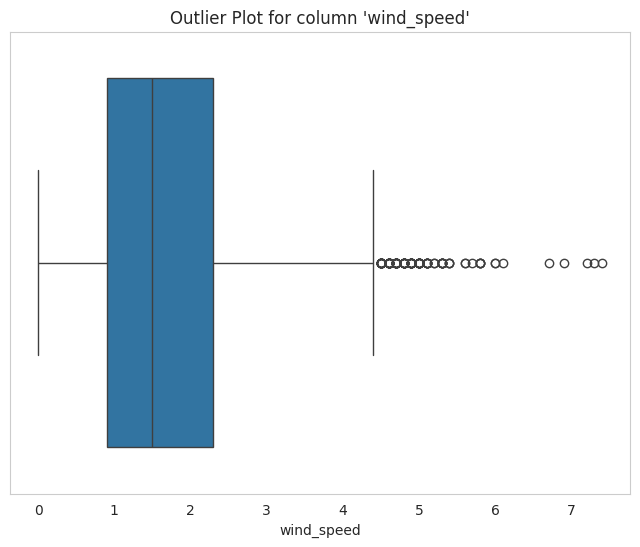

***************************************************************************

No outliers in column 'visibility'.
***************************************************************************

No outliers in column 'dew_point_temperature'.
***************************************************************************

Outliers in column 'solar_radiation':
Outlier Count: 620
Outlier Percentage of total observations: 7.32%
Outlier Values: 2.35, 2.46, 2.39, 2.49, 2.36, 2.5, 2.52, 2.35, 2.48, 2.43, 2.49, 2.95, 2.86, 2.54, 2.61, 2.83, 2.74, 2.48, 2.56, 2.75, 2.66, 2.33, 2.46, 2.45, 2.55, 2.65, 2.47, 2.66, 2.53, 2.47, 2.67, 2.69, 2.34, 2.44, 2.6, 2.43, 2.66, 2.49, 2.38, 2.78, 2.99, 2.91, 2.62, 2.51, 2.52, 2.36, 2.59, 2.33, 2.7, 2.91, 2.82, 2.51, 2.72, 2.87, 2.71, 2.41, 2.48, 2.42, 2.63, 2.75, 2.62, 2.65, 2.8, 2.7, 2.44, 2.54, 2.37, 2.73, 2.87, 2.75, 2.4, 2.41, 2.53, 2.57, 2.83, 3.24, 3.04, 2.79, 2.98, 2.99, 2.49, 2.93, 3.06, 2.99, 2.6, 2.59, 2.94, 2.77, 2.68, 3.07, 3.2, 3.13, 2.86, 2.39, 2.52, 2.7

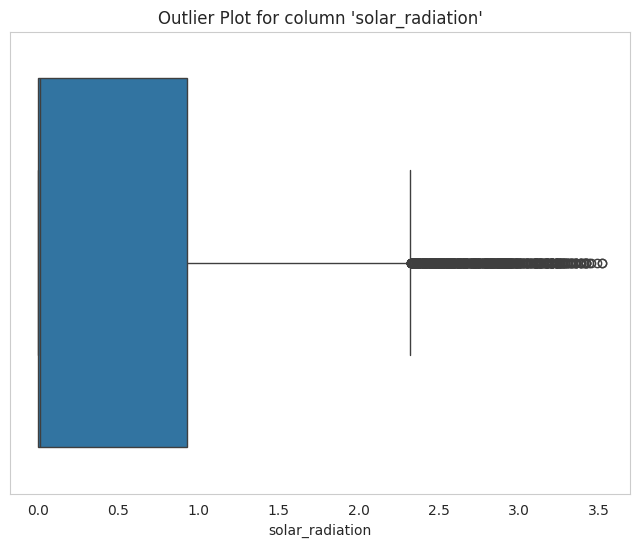

***************************************************************************

Outliers in column 'rainfall':
Outlier Count: 516
Outlier Percentage of total observations: 6.10%
Outlier Values: 0.5, 1.0, 2.5, 0.1, 0.1, 0.2, 0.3, 0.7, 2.5, 1.6, 0.3, 0.4, 1.6, 1.1, 0.1, 0.1, 0.1, 6.4, 9.5, 3.5, 0.5, 0.3, 0.2, 0.2, 1.0, 0.9, 0.5, 0.3, 0.2, 0.2, 0.2, 3.3, 1.4, 1.5, 0.1, 0.4, 0.4, 3.7, 4.5, 9.5, 9.0, 2.0, 0.1, 0.4, 0.1, 0.2, 0.2, 2.0, 9.0, 1.5, 2.0, 0.5, 2.0, 1.5, 0.5, 8.0, 17.0, 2.0, 0.5, 0.3, 0.2, 0.5, 0.5, 0.5, 0.1, 3.5, 7.0, 3.0, 3.0, 2.0, 0.1, 0.4, 1.5, 2.0, 0.5, 0.5, 1.0, 1.0, 1.5, 1.0, 0.5, 0.5, 0.5, 1.5, 2.0, 2.0, 0.5, 0.1, 0.1, 0.1, 1.9, 1.0, 0.5, 1.5, 3.0, 0.2, 0.8, 1.0, 2.0, 1.0, 1.5, 1.5, 0.5, 0.5, 0.3, 0.2, 1.0, 0.5, 0.5, 1.5, 2.5, 4.0, 3.0, 2.0, 0.1, 0.9, 0.5, 3.5, 2.5, 7.0, 6.0, 5.0, 8.0, 4.0, 1.5, 5.5, 2.5, 4.0, 1.5, 1.0, 0.5, 1.0, 1.5, 1.0, 1.5, 0.1, 2.4, 0.5, 0.4, 0.1, 1.0, 3.5, 4.0, 0.5, 0.5, 1.0, 1.0, 0.1, 0.4, 0.5, 0.5, 1.5, 1.5, 2.0, 3.0, 2.5, 2.0, 1.0, 1.5, 3.5, 3.0, 0.4

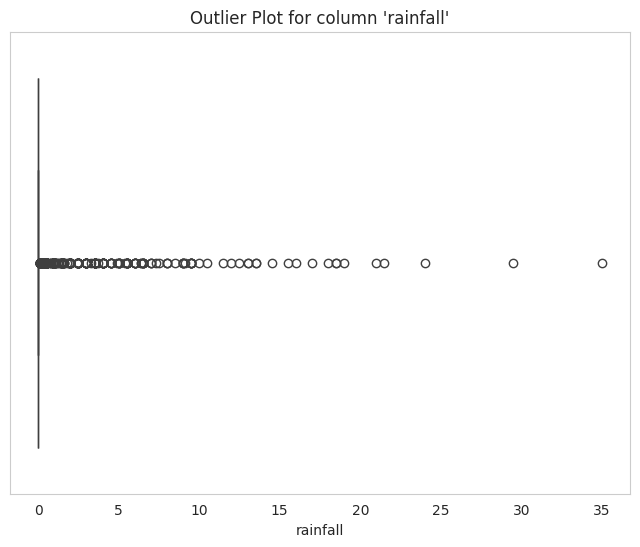

***************************************************************************

Outliers in column 'snowfall':
Outlier Count: 443
Outlier Percentage of total observations: 5.23%
Outlier Values: 0.1, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.3, 0.2, 0.2, 0.2, 0.3, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.7, 0.6, 0.3, 0.7, 2.7, 4.0, 4.1, 4.3, 4.3, 3.9, 3.1, 2.1, 1.4, 1.0, 0.5, 0.4, 0.2, 0.5, 0.7, 0.8, 1.3, 1.8, 2.0, 4.0, 4.8, 4.8, 5.1, 5.0, 4.2, 3.2, 2.7, 2.7, 2.7, 2.7, 2.7, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.5, 2.5, 2.5, 2.5, 2.3, 2.2, 2.2, 2.1, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.9, 1.9, 1.7, 1.7, 1.6, 1.6, 2.2, 2.2, 2.2, 2.4, 2.4, 2.3, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.1, 2.0, 1.9, 1.8, 1.6, 1.0, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.5, 0.2, 0.6, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, 1.0, 0.7,

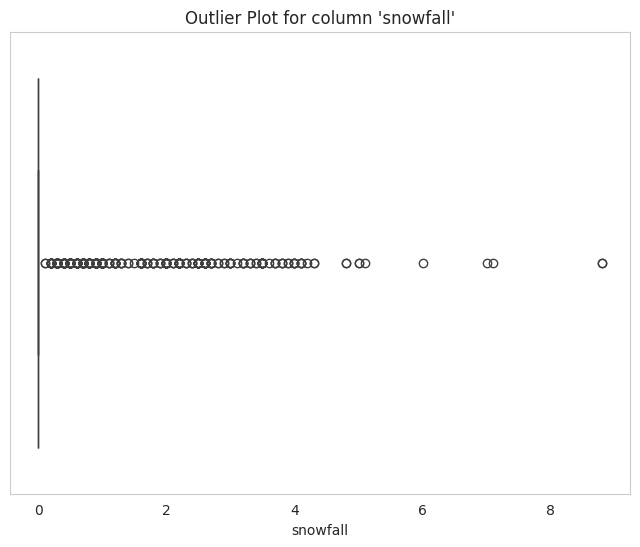

***************************************************************************

No outliers in column 'monday' as it has binary values.
***************************************************************************

No outliers in column 'saturday' as it has binary values.
***************************************************************************

No outliers in column 'sunday' as it has binary values.
***************************************************************************

No outliers in column 'thursday' as it has binary values.
***************************************************************************

No outliers in column 'tuesday' as it has binary values.
***************************************************************************

No outliers in column 'wednesday' as it has binary values.
***************************************************************************

No outliers in column 'spring' as it has binary values.
*************************************************************

Column Outlier Count Outlier Percentage
0       rented_bike_count           152           1.795629
1                    hour             0                0.0
2             temperature             0                0.0
3                humidity             0                0.0
4              wind_speed           139           1.642056
5              visibility             0                0.0
6   dew_point_temperature             0                0.0
7         solar_radiation           620           7.324276
8                rainfall           516           6.095688
9                snowfall           443           5.233314
10                 monday           NaN                NaN
11               saturday           NaN                NaN
12                 sunday           NaN                NaN
13               thursday           NaN                NaN
14                tuesday           NaN                NaN
15              wednesday           NaN                NaN
16                 spring           NaN                NaN
17                 summer           NaN                NaN
18                 winter           NaN                NaN
19                holiday           NaN                NaN

In [32]:
detect_outliers(df)

1. In the "rented_bike_count" column, there are 152 outliers, which account for approximately 1.8% of the total values in this column. These outliers may indicate unusually high or low demand for bike rentals during certain hours.

2. The "wind_speed" column has 139 outliers, which represent about 1.6% of the data. This suggests the presence of strong winds at certain times, which can influence the demand for bikes.

3. The "solar_radiation" column shows 620 outliers, amounting to around 7.3%. This indicates that some measured values of solar radiation were unusually high or low. These outliers could reflect variations in solar activity.

4. The "rainfall" and "snowfall" columns have 516 and 443 outliers, respectively, accounting for approximately 6.1% and 5.2%. This may indicate weather conditions such as heavy rainfall or snowfall, which can affect bike demand.



---


1. For the "rented_bike_count" column, further analysis of these outliers is needed to determine the reasons behind their occurrence. Understanding the factors contributing to the highest impact on bike rental demand can be valuable information.

2. Conducting analysis on the outliers in the "wind_speed", "solar_radiation", "rainfall", and "snowfall" columns, and exploring their relationship with other factors such as temperature, humidity, and visibility can help identify the weather conditions that have the most significant impact on bike demand.

3. If the features"solar_radiation", "rainfall" and "snowfall" have a big impact on the target feature in correlation,  the outliers must be accounted for when making predictions for bike rental demand.

## Data Correlation

### df

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_cou

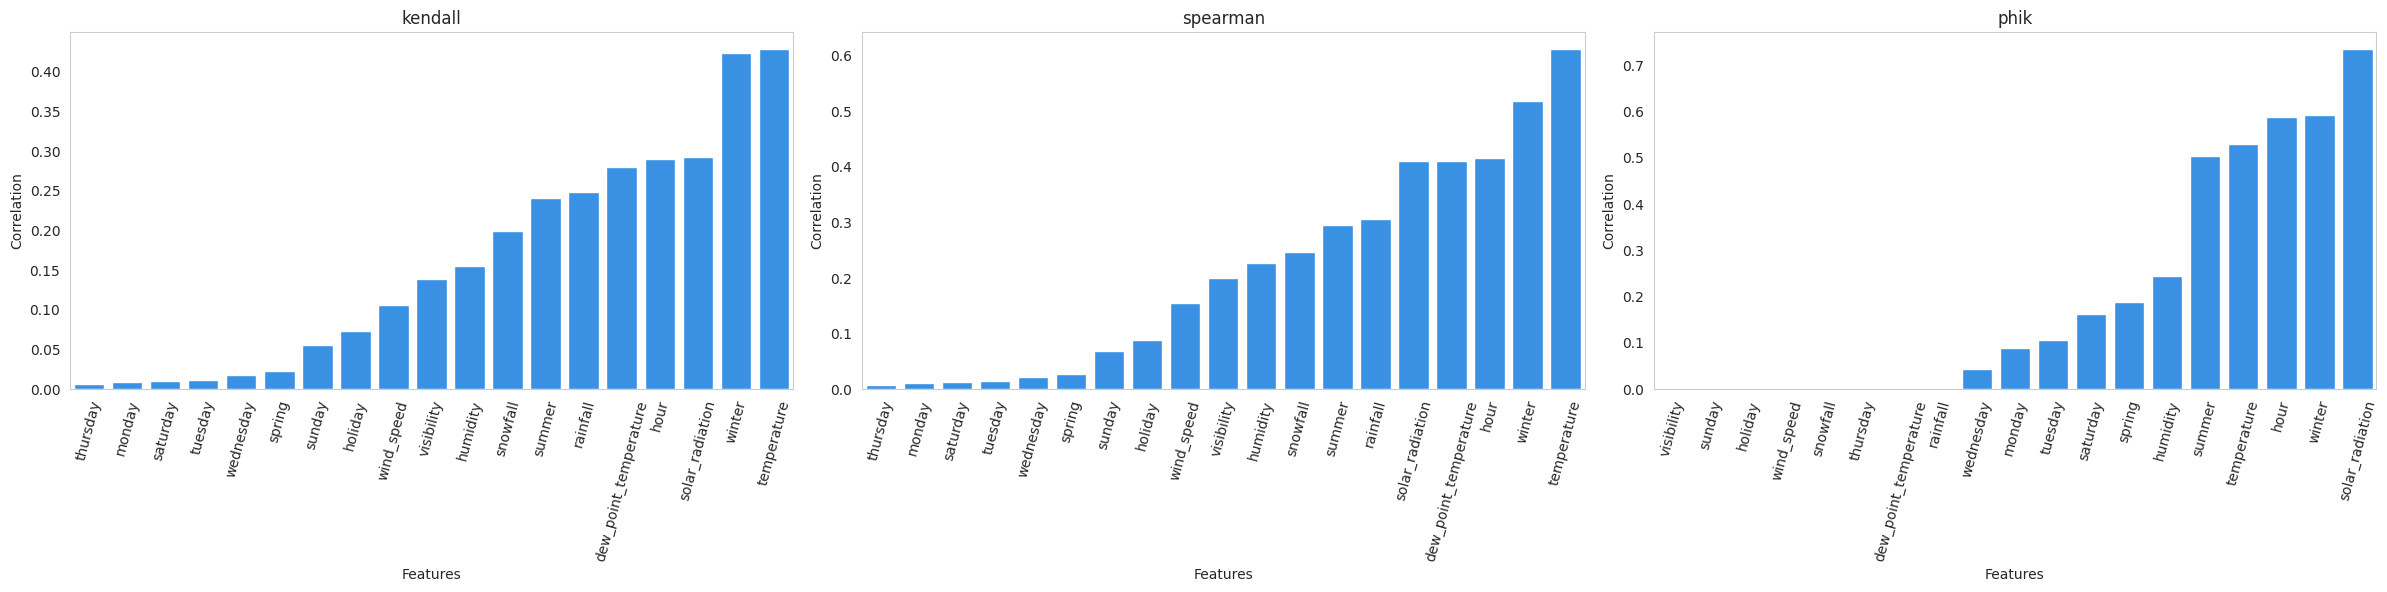

Correlation table with target feature 'rented_bike_count':


Correlation Type        kendall  spearman      phik
Column                                             
temperature            0.428539  0.611726  0.529233
winter                 0.423929  0.518999  0.592327
solar_radiation        0.293117  0.409508  0.734394
hour                   0.289395  0.414948  0.588059
dew_point_temperature  0.279408  0.410788  0.000000
rainfall               0.248205  0.305837  0.000000
summer                 0.240571  0.294521  0.504399
snowfall               0.199050  0.246787  0.000000
humidity               0.155460  0.226477  0.244931
visibility             0.138523  0.198904  0.000000
wind_speed             0.105914  0.154984  0.000000
holiday                0.072477  0.088731  0.000000
sunday                 0.055460  0.067898  0.000000
spring                 0.022033  0.026975  0.188488
wednesday              0.017916  0.021933  0.043378
tuesday                0.011329  0.013870  0.106308
saturday               0.009889  0.012106  0.163018
monday                 0.008263  0.010116  0.088152
thursday               0.005769  0.007063  0.000000


Top 2 features with highest correlation (Kendall): ['temperature', 'winter']

Top 2 features with highest correlation (Spearman): ['temperature', 'winter']

Top 2 features with highest correlation (Phik): ['solar_radiation', 'winter']


In [33]:
# Take a look at Spearman, Kendell and Phi_k correlations with the target variable in df

correlation_analysis(df, 'rented_bike_count', correlation_types=['kendall', 'spearman', 'phik'], apply_abs=True)

Checking for multicollinearity features

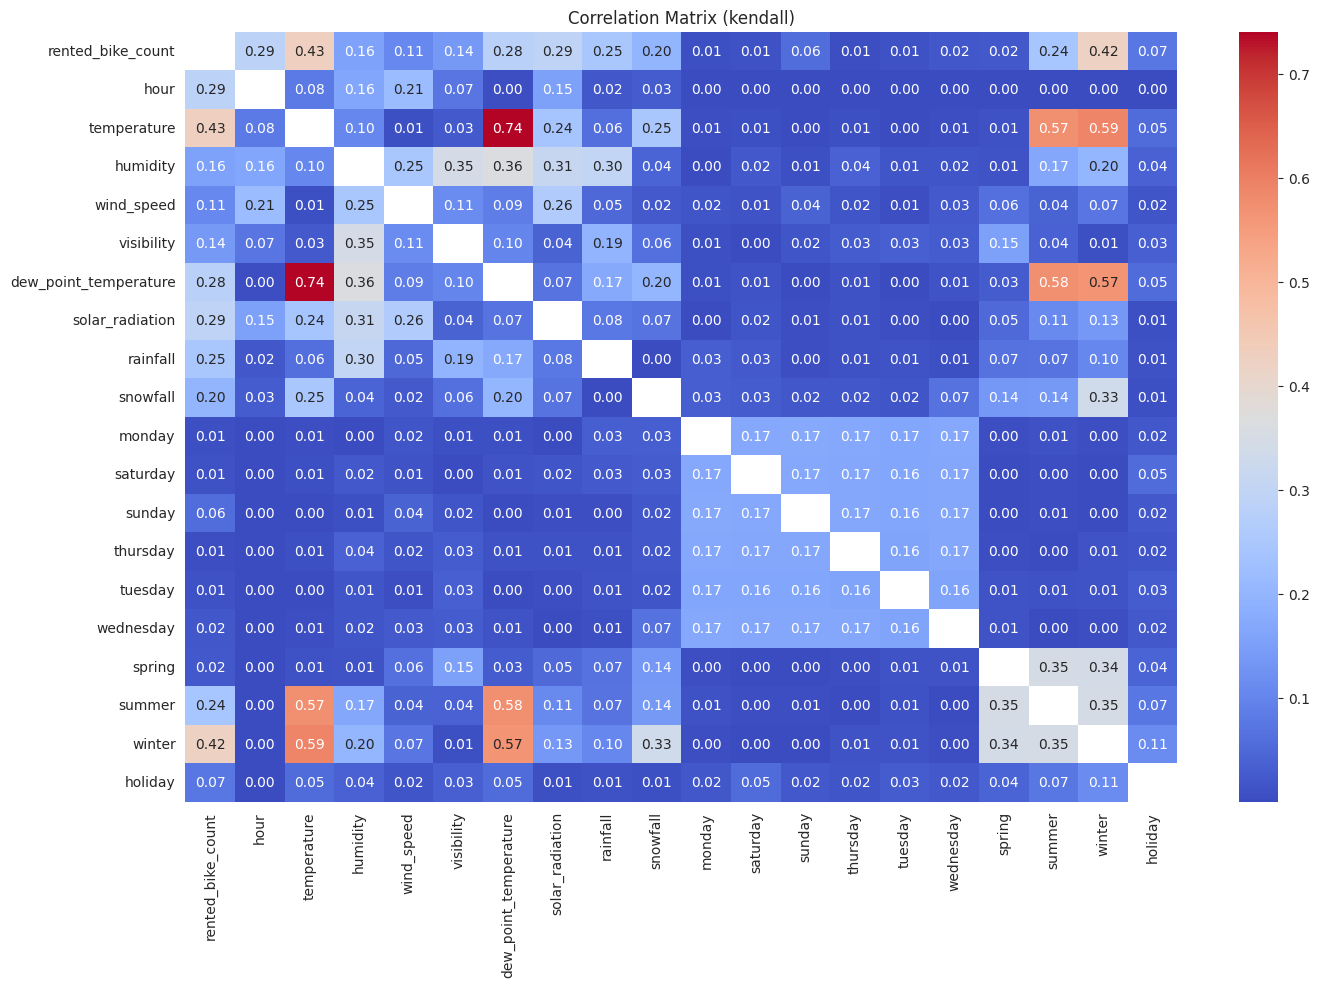

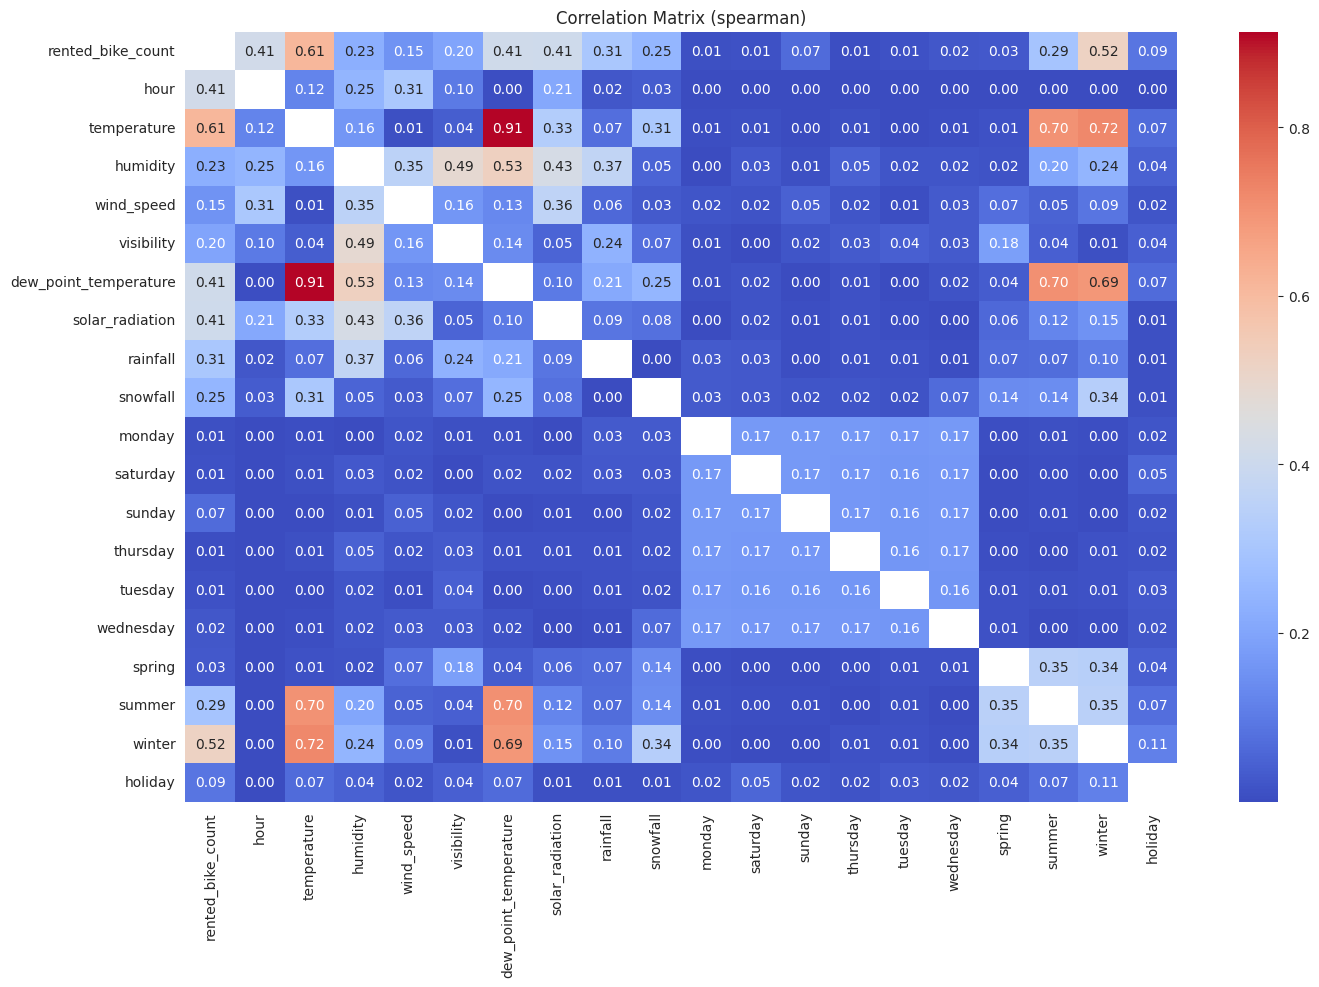

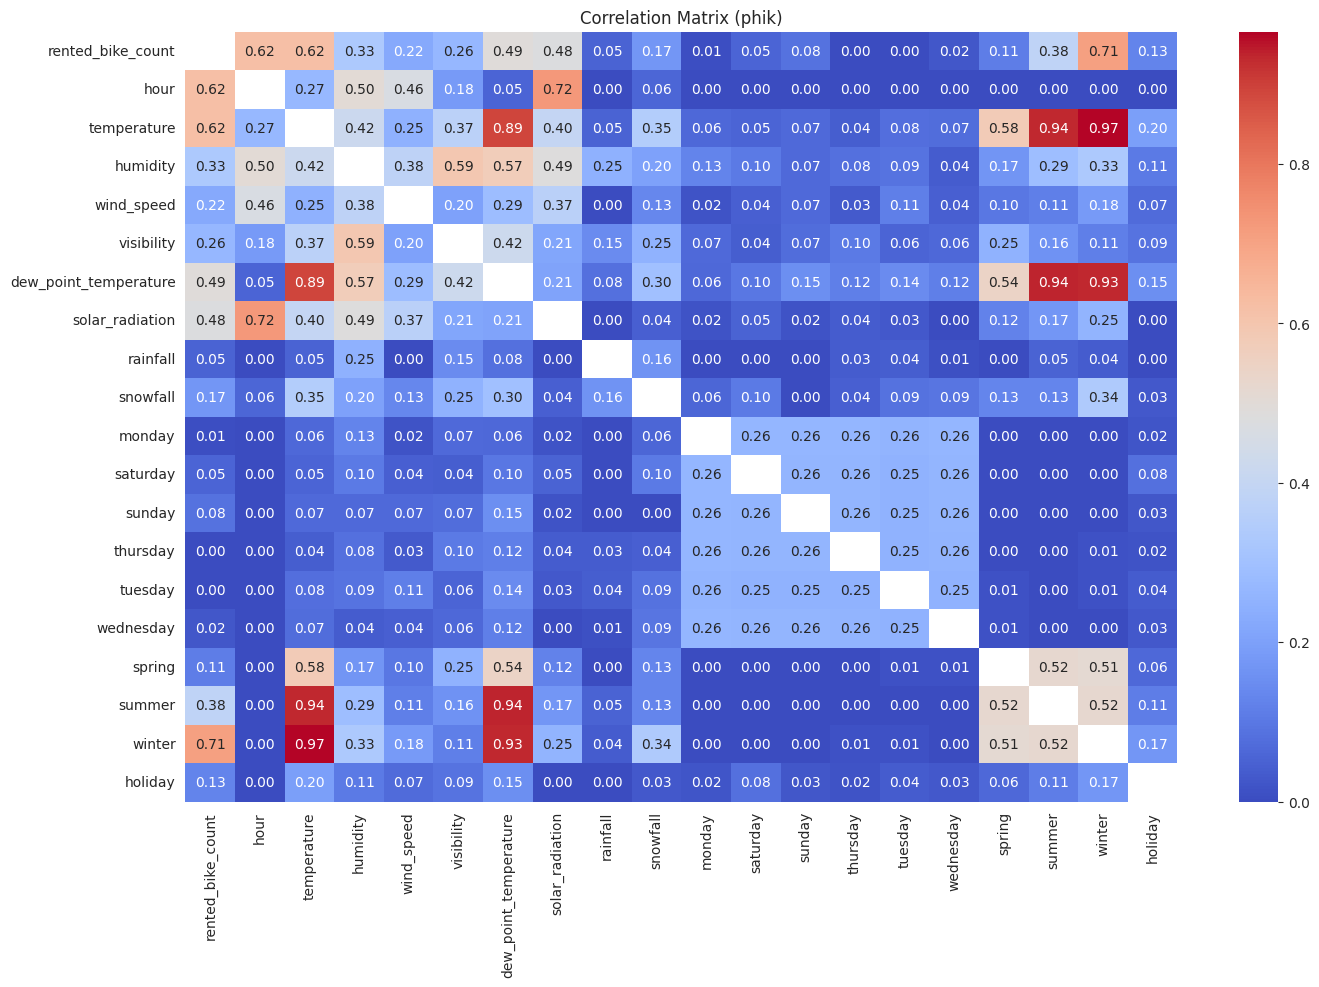


Multicollinearity Table (spearman)


Feature 1              Feature 2  Correlation
0  temperature  dew_point_temperature      0.91372


Multicollinearity Table (phik)


Feature 1              Feature 2  Correlation
2            temperature                 winter     0.966213
3  dew_point_temperature                 summer     0.936662
1            temperature                 summer     0.935591
4  dew_point_temperature                 winter     0.933164
0            temperature  dew_point_temperature     0.892473

In [34]:
methods = ['kendall', 'spearman', 'phik']
find_multicollinearity(df, methods=methods, threshold=0.8)

### df_grouped

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_cou

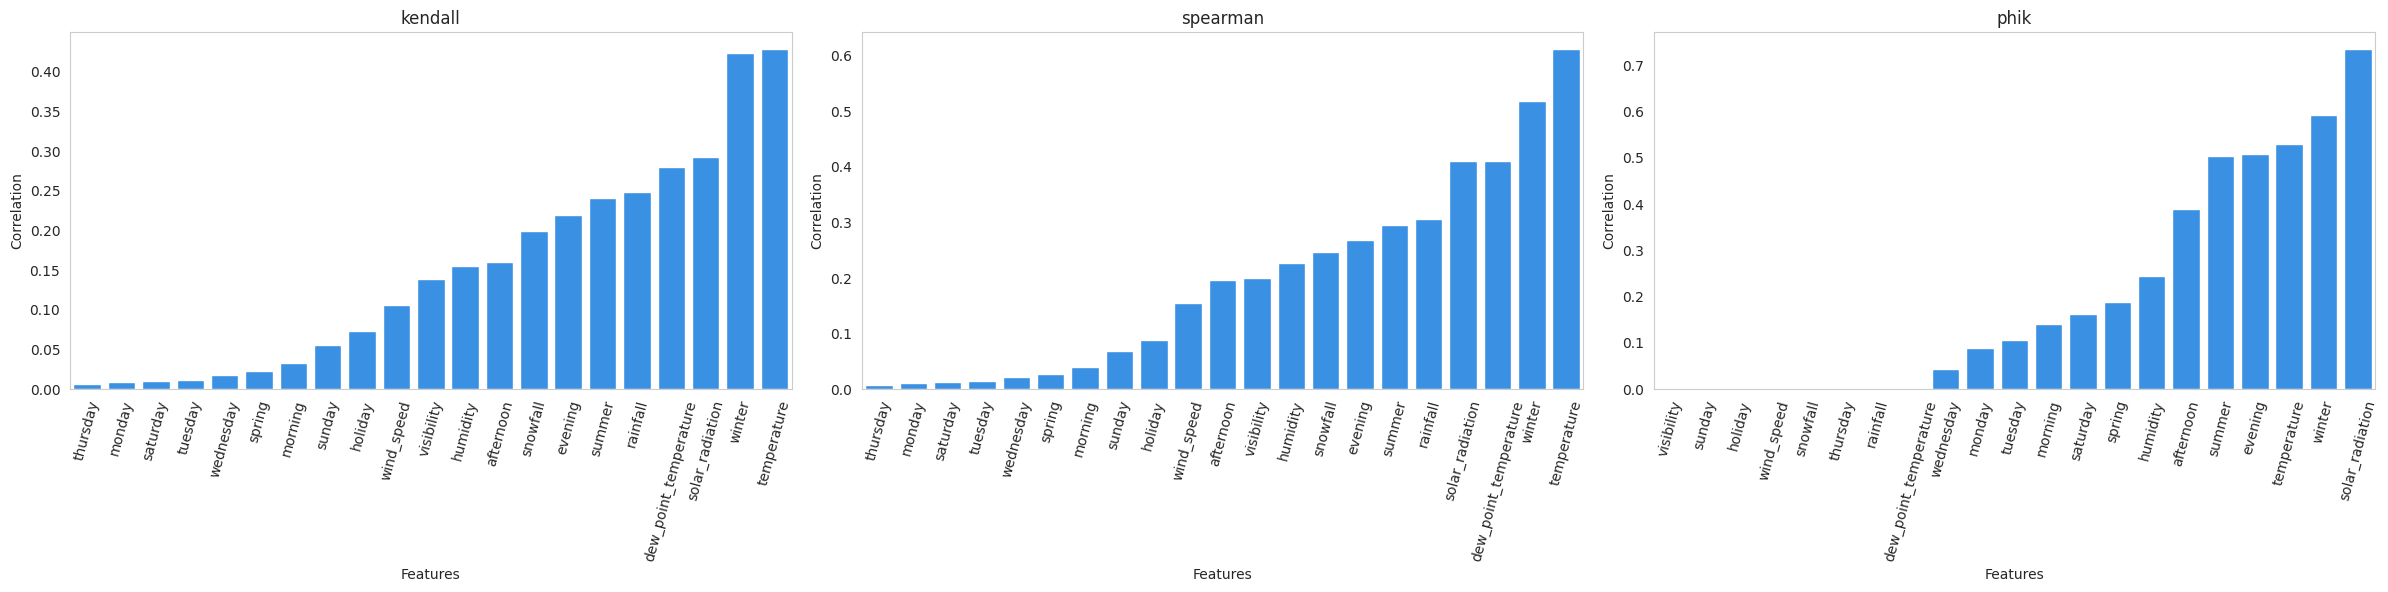

Correlation table with target feature 'rented_bike_count':


Correlation Type        kendall  spearman      phik
Column                                             
temperature            0.428539  0.611726  0.529233
winter                 0.423929  0.518999  0.592327
solar_radiation        0.293117  0.409508  0.734394
dew_point_temperature  0.279408  0.410788  0.000000
rainfall               0.248205  0.305837  0.000000
summer                 0.240571  0.294521  0.504399
evening                0.218798  0.267866  0.508252
snowfall               0.199050  0.246787  0.000000
afternoon              0.160452  0.196435  0.388957
humidity               0.155460  0.226477  0.244931
visibility             0.138523  0.198904  0.000000
wind_speed             0.105914  0.154984  0.000000
holiday                0.072477  0.088731  0.000000
sunday                 0.055460  0.067898  0.000000
morning                0.032108  0.039309  0.139534
spring                 0.022033  0.026975  0.188488
wednesday              0.017916  0.021933  0.043378
tuesday                0.011329  0.013870  0.106308
saturday               0.009889  0.012106  0.163018
monday                 0.008263  0.010116  0.088152
thursday               0.005769  0.007063  0.000000


Top 2 features with highest correlation (Kendall): ['temperature', 'winter']

Top 2 features with highest correlation (Spearman): ['temperature', 'winter']

Top 2 features with highest correlation (Phik): ['solar_radiation', 'winter']


In [35]:
# Take a look at Spearman, Kendell and Phi_k correlations with the target variable in df_grouped

correlation_analysis(df_grouped, 'rented_bike_count', correlation_types=['kendall', 'spearman', 'phik'], apply_abs=True)

Checking for multicollinearity features

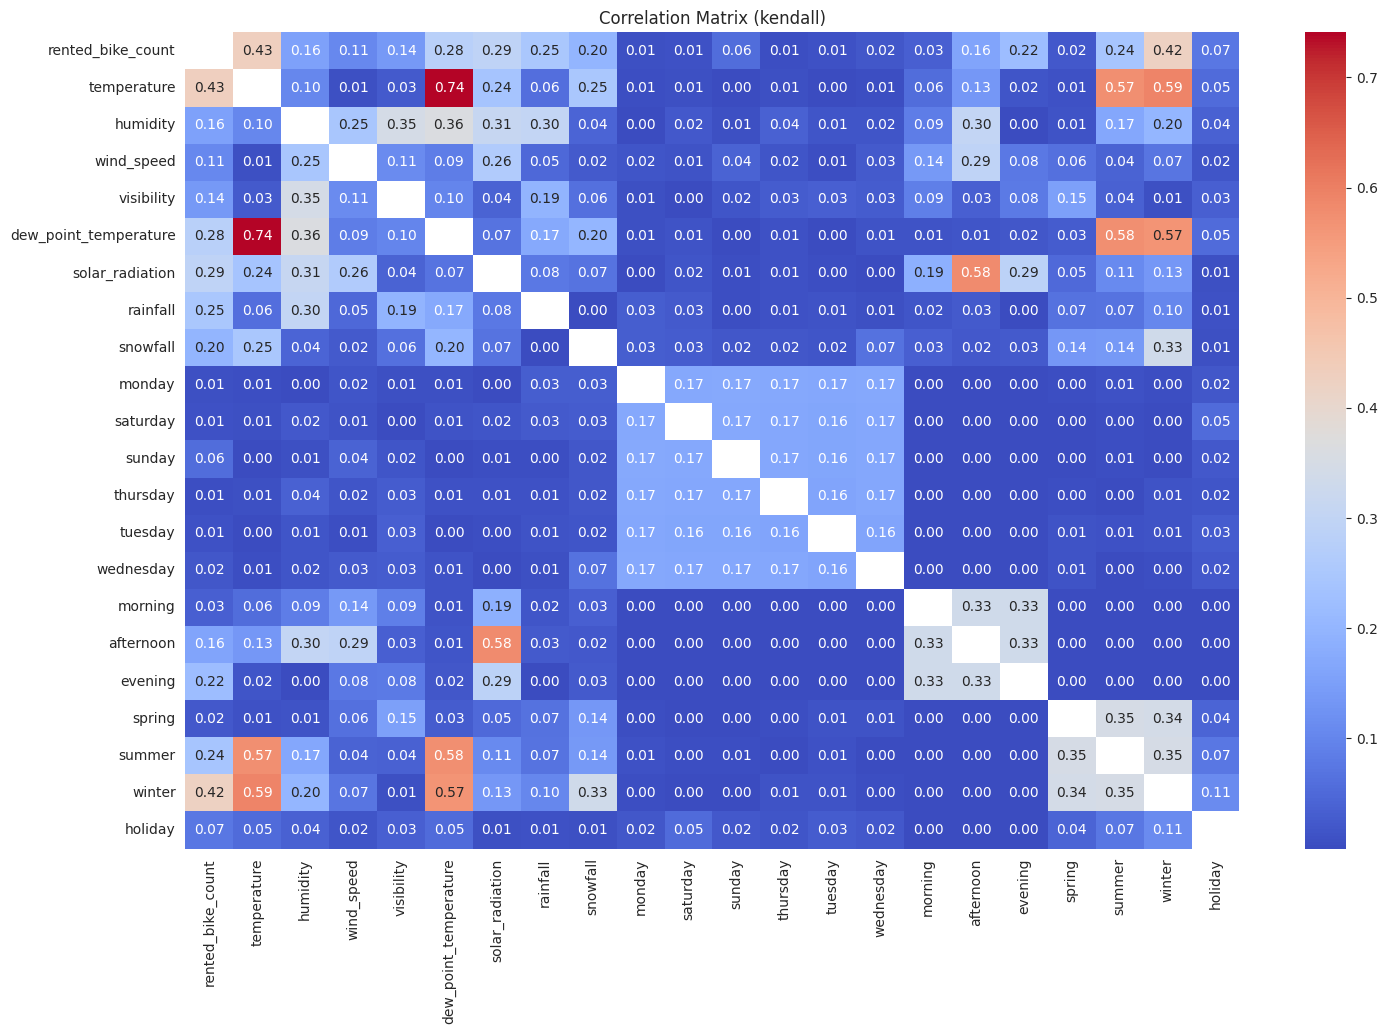

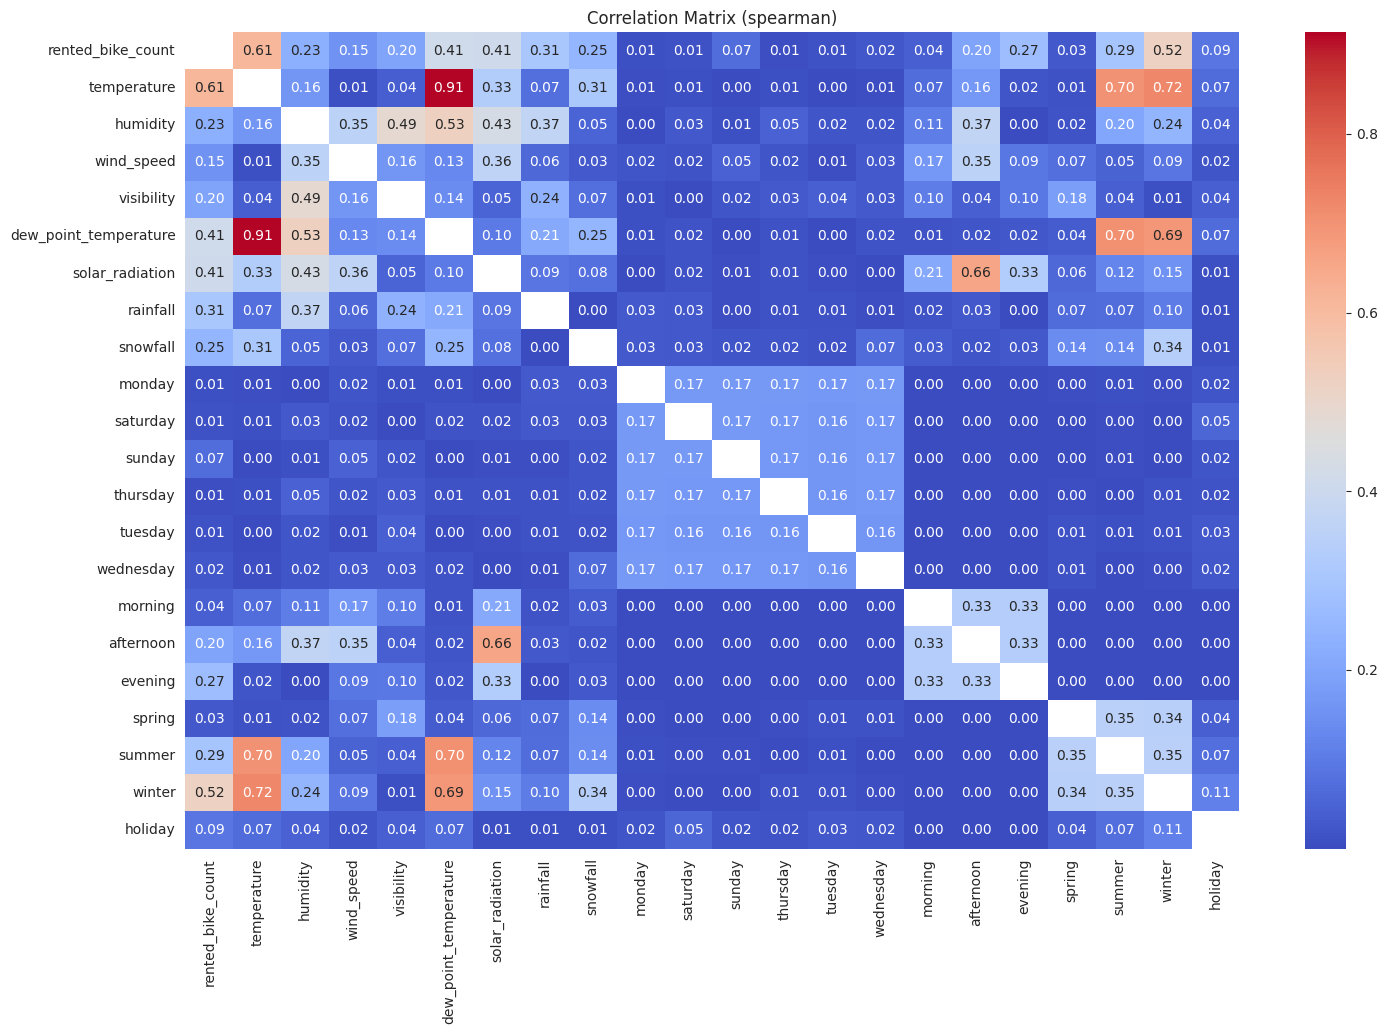

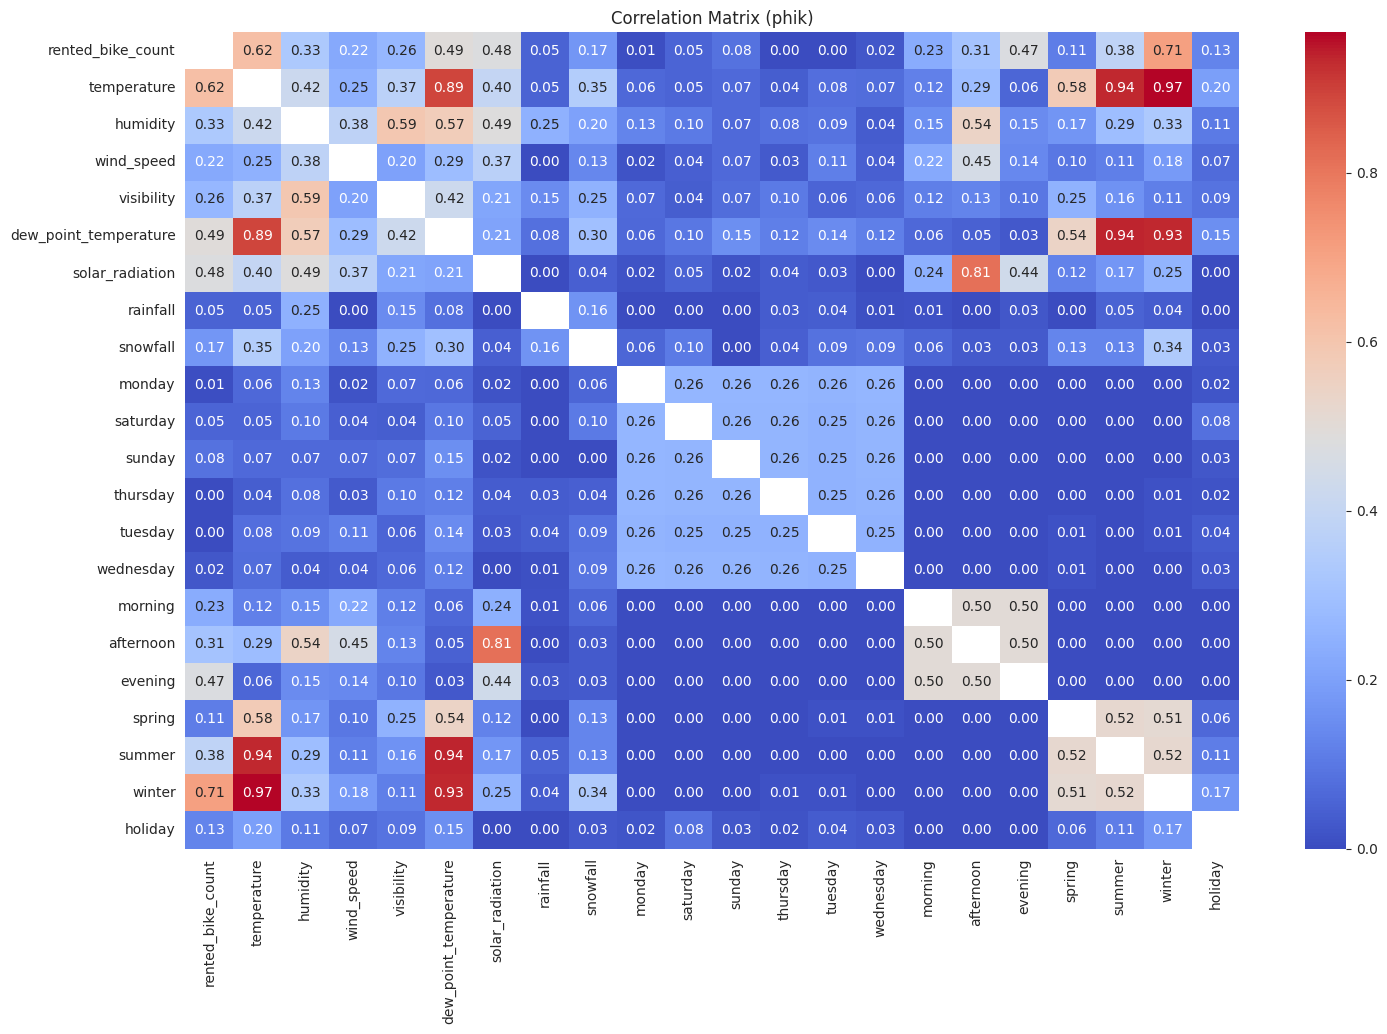


Multicollinearity Table (spearman)


Feature 1              Feature 2  Correlation
0  temperature  dew_point_temperature      0.91372


Multicollinearity Table (phik)


Feature 1              Feature 2  Correlation
2            temperature                 winter     0.966213
3  dew_point_temperature                 summer     0.936662
1            temperature                 summer     0.935591
4  dew_point_temperature                 winter     0.933164
0            temperature  dew_point_temperature     0.892473
5        solar_radiation              afternoon     0.813262

In [36]:
methods = ['kendall', 'spearman', 'phik']
find_multicollinearity(df_grouped, methods=methods, threshold=0.8)

### Subtotals

* Phik detects a fairly strong correlation (over 0.6) of the target feature with 'solar_radiation'. There is also a medium correlation with 'winter', 'hour' / ('evening', 'afternoon'), 'temperature', 'summer'. Correlation with
  'wind_speed', 'visibility', 'dew_point_temperature',
  'rainfall', 'snowfall', 'sunday', 'thursday', 'tuesday', 'wednesday', 'holiday' are completely missing.
* Kendall and Spearman show the highest correlation with 'temperature' and 'winter'.
* Multicoliary signs are present:
     - seasons of the year and temperature indicators ('temperature' - 'summer',
      'temperature' - 'winter',
      'dew_point_temperature' - 'summer',
      'dew_point_temperature' - 'winter')
     - temperature indicators: 'temperature(' - 'dew_point_temperature'
     - solar radiation depending on the time of day: 'hour'/ 'afternoon' - 'solar_radiation'



* Due to strong multicoliarity, the 'dew_point_temperature' feature can be removed for training models:

* The feature 'solar_radiation' can be left for testing for now since it is strongly correlated only with the afternoon hours; in other hours (periods) multicolliarity is not observed.

In [37]:
# Make a copy of the working dataframe to save data

df_base = df.copy()
df_grouped_base = df_grouped.copy()

# Models training

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import metrics
import numpy as np
from sklearn import model_selection
from sklearn import tree

In [39]:
# all processed information is stored in df_base and df_grouped_base
df = df_base.copy()
df_grouped = df_grouped_base.copy()

In [40]:
#columns_to_drop = ['dew_point_temperature(°c)']
columns_to_drop = ['dew_point_temperature']

df.drop(columns=columns_to_drop, axis=1, inplace=True)
df.head(3)

rented_bike_count  hour  temperature  humidity  wind_speed  visibility  \
0                254     0    -5.199219        37    2.199219        2000   
1                204     1    -5.500000        38    0.799805        2000   
2                173     2    -6.000000        39    1.000000        2000   

   solar_radiation  rainfall  snowfall  monday  saturday  sunday  thursday  \
0              0.0       0.0       0.0       0         0       0         0   
1              0.0       0.0       0.0       0         0       0         0   
2              0.0       0.0       0.0       0         0       0         0   

   tuesday  wednesday  spring  summer  winter  holiday  
0        0          0       0       0       1        0  
1        0          0       0       0       1        0  
2        0          0       0       0       1        0

In [41]:
#columns_to_drop = ['dew_point_temperature(°c)']
columns_to_drop = ['dew_point_temperature']

df_grouped.drop(columns=columns_to_drop, axis=1, inplace=True)
df_grouped.head(3)

rented_bike_count  temperature  humidity  wind_speed  visibility  \
0                254    -5.199219        37    2.199219        2000   
1                204    -5.500000        38    0.799805        2000   
2                173    -6.000000        39    1.000000        2000   

   solar_radiation  rainfall  snowfall  monday  saturday  ...  thursday  \
0              0.0       0.0       0.0       0         0  ...         0   
1              0.0       0.0       0.0       0         0  ...         0   
2              0.0       0.0       0.0       0         0  ...         0   

   tuesday  wednesday  morning  afternoon  evening  spring  summer  winter  \
0        0          0        0          0        0       0       0       1   
1        0          0        0          0        0       0       0       1   
2        0          0        0          0        0       0       0       1   

   holiday  
0        0  
1        0  
2        0  

[3 rows x 21 columns]

In [42]:
# Create a dataframe for storing the models' results

# Creating a dataframe
models_df = pd.DataFrame(columns=['Model', 'Adjusted R2', 'RMSE', 'Training time', 'Special model parameters'])

## Functions

In [43]:
# Function for calculating Adjusted R2

import sklearn.metrics as metrics

def adjusted_r2_score(y, y_pred, X):
    r2 = metrics.r2_score(y, y_pred)
    n = X.shape[0]
    k = X.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    return adjusted_r2


## Datasets df & df_grouped comparison

### df

In [44]:
# splitting the df dataset into features (input variables) and target variable

X = df.drop('rented_bike_count', axis=1)
y = df['rented_bike_count']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [45]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

# Creating a linear regression model
baseline_df = linear_model.LinearRegression()

# Performing cross-validation and obtaining predictions for the training set
y_train_predict = model_selection.cross_val_predict(estimator=baseline_df, X=X_train, y=y_train, cv=10)

# Performing cross-validation and obtaining predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=baseline_df, X=X_test, y=y_test, cv=10)

# Calculating adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Calculating RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))


# Calculating the average model training time

# Performing cross-validation with timing of training execution
scores = model_selection.cross_validate(baseline_df, X, y, cv=5, scoring='r2', return_train_score=True)
# Training execution time for each fold
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 0.02 seconds
****************************************
Train Adjusted R2 (CV): 0.538
Test Adjusted R2 (CV): 0.547
****************************************
Train RMSE (CV): 439
Test RMSE (CV): 421


In [46]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['baseline_df'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Training time': [fit_time_mean]})
# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Model  Adjusted R2 RMSE  Training time Special model parameters
0  baseline_df        0.547  421           0.02                      NaN

### df_grouped

In [47]:
# splitting the df_grouped dataset into features (input variables) and target variable

X = df_grouped.drop('rented_bike_count', axis=1)
y = df_grouped['rented_bike_count']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [48]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

# Creating a linear regression model
baseline_df_grouped = linear_model.LinearRegression()

# Performing cross-validation and obtaining predictions for the training set
y_train_predict = model_selection.cross_val_predict(estimator=baseline_df_grouped, X=X_train, y=y_train, cv=10)

# Performing cross-validation and obtaining predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=baseline_df_grouped, X=X_test, y=y_test, cv=10)

# Calculating adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Calculating RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))


# Calculating the average model training time

# Performing cross-validation with timing of training execution
scores = model_selection.cross_validate(baseline_df_grouped, X, y, cv=10, scoring='r2', return_train_score=True)
# Training execution time for each fold
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 0.04 seconds
****************************************
Train Adjusted R2 (CV): 0.572
Test Adjusted R2 (CV): 0.577
****************************************
Train RMSE (CV): 422
Test RMSE (CV): 407


In [49]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['baseline_df_grouped'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Training time': [fit_time_mean]})
# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Model  Adjusted R2 RMSE  Training time  \
0          baseline_df        0.547  421           0.02   
1  baseline_df_grouped        0.577  407           0.04   

  Special model parameters  
0                      NaN  
1                      NaN

### df_s

In [50]:
#df.columns.tolist()

In [51]:
# Removing features from training

X = df.drop(['rented_bike_count', 'wind_speed', 'visibility', 'snowfall',  'monday',
'thursday', 'tuesday', 'wednesday'], axis=1)
y = df['rented_bike_count']
X.head(3)

hour  temperature  humidity  solar_radiation  rainfall  saturday  sunday  \
0     0    -5.199219        37              0.0       0.0         0       0   
1     1    -5.500000        38              0.0       0.0         0       0   
2     2    -6.000000        39              0.0       0.0         0       0   

   spring  summer  winter  holiday  
0       0       0       1        0  
1       0       0       1        0  
2       0       0       1        0

In [52]:
# splitting the df_grouped dataset
X_train_s, X_test_s, y_train_s, y_test_s = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [53]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

# Create a linear regression model
baseline_df_s = linear_model.LinearRegression()

# Perform cross-validation and get predictions for the training set
y_train_predict_s = cross_val_predict(estimator=baseline_df_s, X=X_train_s, y=y_train_s, cv=10)

# Perform cross-validation and get predictions for the test set
y_test_predict_s = cross_val_predict(estimator=baseline_df_s, X=X_test_s, y=y_test_s, cv=10)

# Calculate adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train_s, y_train_predict_s, X_train_s), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test_s, y_test_predict_s, X_test_s), 3)

# Calculate RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train_s, y_train_predict_s)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test_s, y_test_predict_s)))

# Calculate the average training time of the model
# Perform cross-validation with calculation of training execution time
scores = model_selection.cross_validate(baseline_df_s, X, y, cv=5, scoring='r2', return_train_score=True)

# Training execution time for each fold
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 0.03 seconds
****************************************
Train Adjusted R2 (CV): 0.538
Test Adjusted R2 (CV): 0.549
****************************************
Train RMSE (CV): 439
Test RMSE (CV): 421


In [54]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['baseline_df_s'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Training time': [fit_time_mean]})
# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Model  Adjusted R2 RMSE  Training time  \
0          baseline_df        0.547  421           0.02   
1  baseline_df_grouped        0.577  407           0.04   
2        baseline_df_s        0.549  421           0.03   

  Special model parameters  
0                      NaN  
1                      NaN  
2                      NaN

### df_grouped_s

In [55]:
#df_grouped.columns.tolist()

In [56]:
# Removing features from training

X = df_grouped.drop(['rented_bike_count', 'wind_speed', 'visibility', 'snowfall',  'monday',
                     'thursday', 'tuesday', 'wednesday'], axis=1)
y = df_grouped['rented_bike_count']
X.head(3)

temperature  humidity  solar_radiation  rainfall  saturday  sunday  \
0    -5.199219        37              0.0       0.0         0       0   
1    -5.500000        38              0.0       0.0         0       0   
2    -6.000000        39              0.0       0.0         0       0   

   morning  afternoon  evening  spring  summer  winter  holiday  
0        0          0        0       0       0       1        0  
1        0          0        0       0       0       1        0  
2        0          0        0       0       0       1        0

In [57]:
# splitting the df_grouped dataset
X_train_s, X_test_s, y_train_s, y_test_s = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [58]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

# Create a linear regression model
baseline_df_grouped_s = linear_model.LinearRegression()

# Perform cross-validation and get predictions for the training set
y_train_predict_s = model_selection.cross_val_predict(estimator=baseline_df_grouped_s, X=X_train_s, y=y_train_s, cv=10)

# Perform cross-validation and get predictions for the test set
y_test_predict_s = model_selection.cross_val_predict(estimator=baseline_df_grouped_s, X=X_test_s, y=y_test_s, cv=10)

# Calculate adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train_s, y_train_predict_s, X_train_s), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test_s, y_test_predict_s, X_test_s), 3)

# Calculate RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train_s, y_train_predict_s)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test_s, y_test_predict_s)))


# Calculate the average training time of the model

# Perform cross-validation with calculation of training execution time
scores = model_selection.cross_validate(baseline_df_grouped_s, X, y, cv=5, scoring='r2', return_train_score=True)
# Training execution time for each fold
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 0.02 seconds
****************************************
Train Adjusted R2 (CV): 0.572
Test Adjusted R2 (CV): 0.578
****************************************
Train RMSE (CV): 423
Test RMSE (CV): 407


In [59]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['baseline_df_grouped_s'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Training time': [fit_time_mean]})
# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Model  Adjusted R2 RMSE  Training time  \
0            baseline_df        0.547  421           0.02   
1    baseline_df_grouped        0.577  407           0.04   
2          baseline_df_s        0.549  421           0.03   
3  baseline_df_grouped_s        0.578  407           0.02   

  Special model parameters  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN

### Breaf Summary
It was experimentally found that:
* A dataframe with combined hours by periods (df_grouped) is better suited for training logistic models, so in the future it will be used for logistic models;
* Signs 'wind_speed', 'visibility', 'snowfall_(cm)', 'monday',
   'thursday', 'tuesday', 'wednesday' do not affect the strength of the model, so these data will be excluded further for building logistic models.

## Baseline models

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree

Let's train each of the baseline models based on data from these 4 dataframe splits

In [61]:
X = df_grouped.drop(['rented_bike_count', 'wind_speed', 'visibility', 'snowfall',  'monday',
 'thursday', 'tuesday', 'wednesday'], axis=1)
y = df_grouped['rented_bike_count']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)
# best result for LinearRegression

In [62]:
X = df_grouped.drop('rented_bike_count', axis=1)
y = df_grouped['rented_bike_count']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [63]:
X = df.drop(['rented_bike_count', 'wind_speed', 'visibility', 'snowfall',  'monday',
 'thursday', 'tuesday', 'wednesday'], axis=1)
y = df['rented_bike_count']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)


In [64]:
X = df.drop('rented_bike_count', axis=1)
y = df['rented_bike_count']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)
# best result for random forest (adjusted r2, train: 0.915, test: 0.861)

### Decision Tree

In [65]:
# Decision tree without scaling

dt = tree.DecisionTreeRegressor(random_state=42)

# Perform cross-validation and get predictions for the training set
%time y_train_predict = model_selection.cross_val_predict(estimator=dt, X=X_train, y=y_train, cv=5)

# Perform cross-validation and get predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=dt, X=X_test, y=y_test, cv=5)

# Calculate adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Calculate RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

CPU times: user 218 ms, sys: 858 µs, total: 219 ms
Wall time: 224 ms
****************************************
Train Adjusted R2 (CV): 0.85
Test Adjusted R2 (CV): 0.732
****************************************
Train RMSE (CV): 250
Test RMSE (CV): 324


In [66]:
# Pipeline with normalization for decision tree

pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', tree.DecisionTreeRegressor(random_state=42))])

# Perform cross-validation and get predictions for the training set
%time y_train_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_train, y=y_train, cv=5)

# Perform cross-validation and get predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_test, y=y_test, cv=5)

# Calculate adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Calculate RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

CPU times: user 239 ms, sys: 3.77 ms, total: 243 ms
Wall time: 249 ms
****************************************
Train Adjusted R2 (CV): 0.85
Test Adjusted R2 (CV): 0.732
****************************************
Train RMSE (CV): 250
Test RMSE (CV): 324


### Random Forest

In [67]:
# Random Forest without scaling

rf = RandomForestRegressor(random_state=42)

# Perform cross-validation and get predictions for the training set
%time y_train_predict = model_selection.cross_val_predict(estimator=rf, X=X_train, y=y_train, cv=5)

# Perform cross-validation and get predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=rf, X=X_test, y=y_test, cv=5)

# Calculate adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Calculate RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

CPU times: user 13.6 s, sys: 26.5 ms, total: 13.7 s
Wall time: 13.7 s
****************************************
Train Adjusted R2 (CV): 0.918
Test Adjusted R2 (CV): 0.861
****************************************
Train RMSE (CV): 184
Test RMSE (CV): 233


In [68]:
# Pipeline with normalization for Random Forest

pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', RandomForestRegressor(random_state=42))])

# Perform cross-validation and get predictions for the training set
%time y_train_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_train, y=y_train, cv=5)

# Perform cross-validation and get predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_test, y=y_test, cv=5)

# Calculate adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Calculate RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

CPU times: user 14 s, sys: 24.7 ms, total: 14 s
Wall time: 17.2 s
****************************************
Train Adjusted R2 (CV): 0.919
Test Adjusted R2 (CV): 0.861
****************************************
Train RMSE (CV): 184
Test RMSE (CV): 233


### LinearRegression

In [69]:
# Linear regression without scaling

reg = linear_model.LinearRegression()

# Perform cross-validation and get predictions for the training set
%time y_train_predict = model_selection.cross_val_predict(estimator=reg, X=X_train, y=y_train, cv=5)

# Perform cross-validation and get predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=reg, X=X_test, y=y_test, cv=5)

# Calculate adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Calculate RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

CPU times: user 68.2 ms, sys: 42 ms, total: 110 ms
Wall time: 64.6 ms
****************************************
Train Adjusted R2 (CV): 0.539
Test Adjusted R2 (CV): 0.548
****************************************
Train RMSE (CV): 439
Test RMSE (CV): 421


In [70]:
# Pipeline with normalization for decision tree

pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', linear_model.LinearRegression())])

# Perform cross-validation and get predictions for the training set
%time y_train_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_train, y=y_train, cv=5)

# Perform cross-validation and get predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_test, y=y_test, cv=5)

# Calculate adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Calculate RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

CPU times: user 145 ms, sys: 193 ms, total: 338 ms
Wall time: 178 ms
****************************************
Train Adjusted R2 (CV): 0.539
Test Adjusted R2 (CV): 0.548
****************************************
Train RMSE (CV): 439
Test RMSE (CV): 421


### Subtotals

* Data scaling affects the strength of the models, but not so huge;
* The best result shows a random forest on a dataframe with information about the clock (dataframe df):
   - Train Adjusted R2 (CV): 0.915 - Test Adjusted R2 (CV): 0.868
   - Train RMSE (CV): 184 - Test RMSE (CV): 233;

## Random Forest tuning

### Training using all fratures

Let's try to select the most optimal hyperparameters and increase the predictive power of the model

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn import tree

In [72]:
X = df.drop('rented_bike_count', axis=1)
y = df['rented_bike_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [73]:
# Train the base random forest model
from sklearn.preprocessing import StandardScaler

# Data standardization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_base = RandomForestRegressor(random_state=42)

# Perform cross-validation and get predictions for the training set
y_train_predict = model_selection.cross_val_predict(estimator=rf_base, X=X_train_scaled, y=y_train, cv=5)

# Perform cross-validation and get predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=rf_base, X=X_test_scaled, y=y_test, cv=5)

# Calculate adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train_scaled), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test_scaled), 3)

# Calculate RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

# Calculate the average model fitting time
# Perform cross-validation with timing of the fitting process
scores = model_selection.cross_validate(rf_base, X_train_scaled, y_train, cv=5, scoring='r2', return_train_score=True)

# Calculate the average model fitting time
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 3.63 seconds
****************************************
Train Adjusted R2 (CV): 0.919
Test Adjusted R2 (CV): 0.861
****************************************
Train RMSE (CV): 184
Test RMSE (CV): 233


In [74]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['rf_base'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Training time': [fit_time_mean]})
# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Model  Adjusted R2 RMSE  Training time  \
0            baseline_df        0.547  421           0.02   
1    baseline_df_grouped        0.577  407           0.04   
2          baseline_df_s        0.549  421           0.03   
3  baseline_df_grouped_s        0.578  407           0.02   
4                rf_base        0.861  233           3.63   

  Special model parameters  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN

In [75]:
# Explore the depth of the trees

# Create and train the random forest
rf_base.fit(X_train, y_train)
all_trees = rf_base.estimators_

depths = [tree.tree_.max_depth for tree in all_trees if tree.tree_ is not None]  # Check for None
average_depth = np.mean(depths) if depths else None  # Conditional check before calculating the average depth

print(f"Depth of each tree: {depths}")
print(f"Average depth of the random forest: {average_depth}")

Depth of each tree: [27, 29, 28, 29, 27, 28, 31, 28, 26, 30, 31, 26, 27, 26, 27, 26, 29, 29, 27, 27, 27, 26, 31, 30, 26, 28, 26, 29, 28, 28, 26, 30, 27, 29, 29, 28, 24, 26, 26, 27, 27, 27, 28, 26, 27, 28, 25, 27, 28, 28, 27, 28, 27, 26, 27, 28, 25, 28, 27, 26, 29, 29, 27, 29, 29, 26, 28, 29, 28, 28, 28, 27, 29, 28, 27, 27, 28, 28, 28, 26, 30, 28, 27, 28, 27, 30, 28, 27, 28, 28, 27, 27, 27, 30, 28, 29, 27, 27, 28, 26]
Average depth of the random forest: 27.64


In [76]:
# Explore the leaves of the trees

leaf_counts = [tree.tree_.n_leaves for tree in all_trees]
average_leaf_count = np.mean(leaf_counts)
print(f"Number of leaves in each tree: {leaf_counts}")
print(f"Average number of leaves in a tree: {average_leaf_count}")

Number of leaves in each tree: [3953, 4004, 3966, 3977, 3945, 4018, 3939, 3961, 3961, 4020, 3972, 3939, 3934, 3926, 3960, 3907, 3940, 3910, 3960, 3946, 3982, 3929, 3964, 3983, 3980, 3962, 3970, 3992, 3910, 3959, 3979, 4032, 3984, 3946, 3945, 4027, 3994, 3989, 3894, 3955, 3919, 3905, 3975, 3962, 3989, 3901, 3980, 3948, 3968, 3962, 4014, 3978, 3990, 3942, 3973, 3955, 3921, 3951, 3912, 3945, 3982, 3973, 3969, 3957, 3977, 3939, 3974, 3916, 3926, 3946, 3936, 3953, 3935, 3921, 3950, 3957, 3929, 3983, 3997, 3949, 3974, 3961, 3975, 3978, 3961, 3940, 3960, 3982, 3915, 3959, 3957, 3957, 4018, 3940, 3891, 3910, 3967, 3962, 3980, 4002]
Average number of leaves in a tree: 3958.62


The number of leaves is too large

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'hour'),
  Text(1, 0, 'temperature'),
  Text(2, 0, 'humidity'),
  Text(3, 0, 'wind_speed'),
  Text(4, 0, 'visibility'),
  Text(5, 0, 'solar_radiation'),
  Text(6, 0, 'rainfall'),
  Text(7, 0, 'snowfall'),
  Text(8, 0, 'monday'),
  Text(9, 0, 'saturday'),
  Text(10, 0, 'sunday'),
  Text(11, 0, 'thursday'),
  Text(12, 0, 'tuesday'),
  Text(13, 0, 'wednesday'),
  Text(14, 0, 'spring'),
  Text(15, 0, 'summer'),
  Text(16, 0, 'winter'),
  Text(17, 0, 'holiday')])

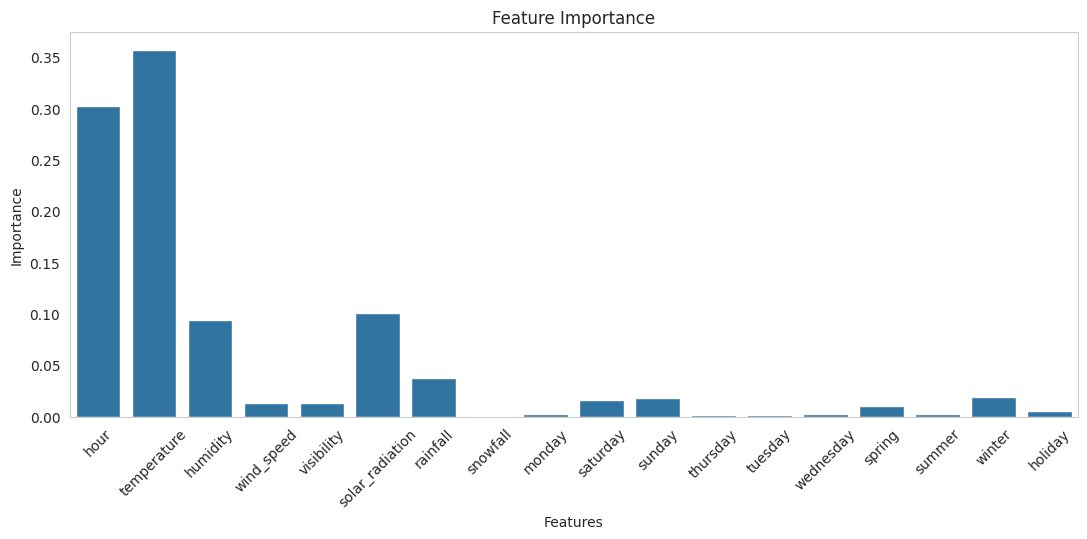

In [77]:
# Explore feature importance
rf_base.fit(X_train, y_train)
plt.figure(figsize=(13, 5))
feature = X_train.columns
feature_importances = rf_base.feature_importances_
sns.barplot(x=feature, y=feature_importances)
# Add labels to the plot, x-axis, and y-axis
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)

Let's try to select the optimal hyperparameters of the model

#### Hyperopt

In [93]:
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'criterion': hp.choice('criterion', ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'])
}

def hyperopt_rf(params, cv=5, X=X_train, y=y_train):
    model = RandomForestRegressor(**params)
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()
    return -score

trials = Trials()
best = fmin(hyperopt_rf,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42)
           )

print(f"Best hyperparameter values: {best}")

100%|██████████| 100/100 [47:23<00:00, 28.44s/trial, best loss: -0.917214945355511]
Best hyperparameter values: {'criterion': 0, 'max_depth': 11, 'max_features': 2, 'min_samples_split': 5, 'n_estimators': 84}


Best hyperparameter values: {'criterion': 0, 'max_depth': 11, 'max_features': 2, 'min_samples_split': 5, 'n_estimators': 84}

In [ ]:
# # Let's continue to look for the most optimal parameters

# best = fmin(hyperopt_rf,  # our function
#             space=space,  # hyperparameter space
#             algo=tpe.suggest,  # optimization algorithm, set by default, not required to specify
#             max_evals=200,  # maximum number of iterations
#             trials=trials,  # logging results
#             rstate=np.random.default_rng(random_state)  # set for result reproducibility
#            )
# print(f"Best hyperparameter values: {best}")

 53%|█████▎    | 106/200 [00:11<03:00,  1.92s/trial, best loss: -0.8604947888166571]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 57%|█████▋    | 114/200 [00:37<03:24,  2.38s/trial, best loss: -0.8604947888166571]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 60%|██████    | 121/200 [00:54<02:18,  1.75s/trial, best loss: -0.8604947888166571]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 64%|██████▍   | 128/200 [01:06<01:33,  1.30s/trial, best loss: -0.8604947888166571]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 68%|██████▊   | 135/200 [01:21<01:51,  1.72s/trial, best loss: -0.8604947888166571]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 71%|███████   | 142/200 [01:33<01:56,  2.01s/trial, best loss: -0.8604947888166571]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 96%|█████████▌| 192/200 [04:43<00:19,  2.40s/trial, best loss: -0.8860620375839618]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 99%|█████████▉| 198/200 [04:58<00:04,  2.39s/trial, best loss: -0.8860620375839618]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



100%|██████████| 200/200 [05:04<00:00,  3.05s/trial, best loss: -0.8860620375839618]
Best hyperparameter values: {'bootstrap': 0, 'criterion': 1, 'max_depth': 15, 'max_features': 2, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0016616160866708015, 'n_estimators': 104, 'random_state': 2}


In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection, metrics
import numpy as np

rf_best = RandomForestRegressor(
    random_state=42,
    n_estimators=int(best['n_estimators']),
    min_samples_leaf=1,
    max_depth=int(best['max_depth']),
    criterion=['poisson', 'squared_error', 'absolute_error', 'friedman_mse'][best['criterion']],
)

# Perform cross-validation and get predictions for the training set
y_train_predict = model_selection.cross_val_predict(estimator=rf_best, X=X_train, y=y_train, cv=5)

# Perform cross-validation and get predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=rf_best, X=X_test, y=y_test, cv=5)

adjusted_r2_train = round(metrics.r2_score(y_train, y_train_predict), 3)
adjusted_r2_test = round(metrics.r2_score(y_test, y_test_predict), 3)

# Calculate RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

# Calculate the average model training time
# Perform cross-validation including timing the training process
scores = model_selection.cross_validate(rf_best, X_train, y_train, cv=5, scoring='r2', return_train_score=True, n_jobs=-1)

# Calculate the average model training time
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")


Average fit time: 2.67 seconds
****************************************
Train Adjusted R2 (CV): 0.901
Test Adjusted R2 (CV): 0.866
****************************************
Train RMSE (CV): 203
Test RMSE (CV): 230


In [95]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['rf_best'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Training time': [fit_time_mean],
                        'Special model parameters':
                         ["criterion='poisson', 'max_depth': 11, 'max_features': 2, 'min_samples_split': 5, 'n_estimators': 84"]})

# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Model  Adjusted R2 RMSE  Training time  \
0            baseline_df        0.547  421           0.02   
1    baseline_df_grouped        0.577  407           0.04   
2          baseline_df_s        0.549  421           0.03   
3  baseline_df_grouped_s        0.578  407           0.02   
4                rf_base        0.861  233           3.63   
5                rf_best        0.866  230           2.67   

                            Special model parameters  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5  criterion='poisson', 'max_depth': 11, 'max_fea...

### Training using subset of features

Let's try to select the most optimal hyperparameters and increase the predictive power of the model

In [96]:
X = df.drop(['rented_bike_count', 'monday', 'thursday', 'tuesday', 'wednesday'], axis=1)
y = df['rented_bike_count']
X.head(3)

hour  temperature  humidity  wind_speed  visibility  solar_radiation  \
0     0    -5.199219        37    2.199219        2000              0.0   
1     1    -5.500000        38    0.799805        2000              0.0   
2     2    -6.000000        39    1.000000        2000              0.0   

   rainfall  snowfall  saturday  sunday  spring  summer  winter  holiday  
0       0.0       0.0         0       0       0       0       1        0  
1       0.0       0.0         0       0       0       0       1        0  
2       0.0       0.0         0       0       0       0       1        0

In [97]:
X_train_s, X_test_s, y_train_s, y_test_s = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [98]:
# Train the base random forest model

# Data Standardization
scaler = MinMaxScaler()
X_train_scaled_s = scaler.fit_transform(X_train_s)
X_test_scaled_s = scaler.transform(X_test_s)

# Create an instance of the RandomForestRegressor class
rf_base_s = RandomForestRegressor()

# Perform cross-validation and get predictions for the training set
y_train_predict = model_selection.cross_val_predict(estimator=rf_base_s, X=X_train_scaled_s, y=y_train_s, cv=5)

# Perform cross-validation and get predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=rf_base_s, X=X_test_scaled_s, y=y_test_s, cv=5)

# Calculate adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train_s, y_train_predict, X_train_scaled_s), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test_s, y_test_predict, X_test_scaled_s), 3)

# Calculate RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train_s, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test_s, y_test_predict)))

# Calculate the average model training time
# Perform cross-validation including timing the training process
scores = model_selection.cross_validate(rf_base_s, X_train_scaled_s, y_train_s, cv=5, scoring='r2', return_train_score=True)

# Calculate the average model training time
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 2.49 seconds
****************************************
Train Adjusted R2 (CV): 0.917
Test Adjusted R2 (CV): 0.864
****************************************
Train RMSE (CV): 186
Test RMSE (CV): 231


In [99]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['rf_base_s'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Training time': [fit_time_mean]})
# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Model  Adjusted R2 RMSE  Training time  \
0            baseline_df        0.547  421           0.02   
1    baseline_df_grouped        0.577  407           0.04   
2          baseline_df_s        0.549  421           0.03   
3  baseline_df_grouped_s        0.578  407           0.02   
4                rf_base        0.861  233           3.63   
5                rf_best        0.866  230           2.67   
6              rf_base_s        0.864  231           2.49   

                            Special model parameters  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5  criterion='poisson', 'max_depth': 11, 'max_fea...  
6                                                NaN

In [100]:
# Explore the depth of the trees

# Create and train the random forest
rf_base_s.fit(X_train_s, y_train_s)
all_trees = rf_base_s.estimators_

depths = [tree.tree_.max_depth for tree in all_trees if tree.tree_ is not None]  # Check for None
average_depth = np.mean(depths) if depths else None  # Conditional check before calculating the average depth

print(f"Depth of each tree: {depths}")
print(f"Average depth of the random forest: {average_depth}")

Depth of each tree: [25, 27, 27, 30, 28, 27, 27, 27, 27, 26, 27, 26, 28, 28, 27, 26, 29, 28, 26, 30, 27, 27, 32, 29, 27, 29, 29, 26, 25, 27, 26, 28, 28, 28, 27, 31, 27, 25, 29, 26, 29, 26, 29, 26, 33, 28, 32, 27, 26, 27, 28, 27, 26, 26, 30, 30, 28, 28, 28, 27, 28, 27, 28, 25, 26, 27, 26, 27, 31, 26, 27, 28, 27, 28, 29, 30, 27, 26, 28, 33, 26, 27, 27, 26, 26, 26, 29, 25, 27, 28, 26, 29, 28, 28, 31, 26, 30, 29, 27, 29]
Average depth of the random forest: 27.64


In [101]:
# Explore the depth of the leaves

leaf_counts = [tree.tree_.n_leaves for tree in all_trees]
average_leaf_count = np.mean(leaf_counts)
print(f"Number of leaves in each tree: {leaf_counts}")
print(f"Average number of leaves in a tree: {average_leaf_count}")

Number of leaves in each tree: [3987, 3951, 4008, 3981, 3923, 3972, 3961, 3983, 3957, 4001, 3981, 3983, 4002, 3993, 3930, 3974, 3971, 3927, 3982, 3981, 3988, 4005, 3984, 3964, 3924, 3922, 3965, 3958, 3946, 3986, 3963, 3977, 3941, 3976, 3960, 3959, 3954, 3983, 3973, 3982, 3986, 3932, 4001, 3980, 3964, 3950, 3957, 3941, 3943, 3953, 3966, 3934, 3963, 3929, 3946, 3966, 3946, 3984, 3972, 3912, 3966, 3999, 3964, 3920, 3992, 3989, 3950, 3967, 4010, 3954, 3968, 3926, 3971, 3921, 3970, 3980, 3944, 3978, 3955, 3942, 4000, 3965, 3942, 3928, 3986, 3953, 3998, 3943, 3975, 3990, 3988, 3983, 3948, 3900, 3985, 3943, 3981, 3970, 3953, 3953]
Average number of leaves in a tree: 3964.33


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'hour'),
  Text(1, 0, 'temperature'),
  Text(2, 0, 'humidity'),
  Text(3, 0, 'wind_speed'),
  Text(4, 0, 'visibility'),
  Text(5, 0, 'solar_radiation'),
  Text(6, 0, 'rainfall'),
  Text(7, 0, 'snowfall'),
  Text(8, 0, 'saturday'),
  Text(9, 0, 'sunday'),
  Text(10, 0, 'spring'),
  Text(11, 0, 'summer'),
  Text(12, 0, 'winter'),
  Text(13, 0, 'holiday')])

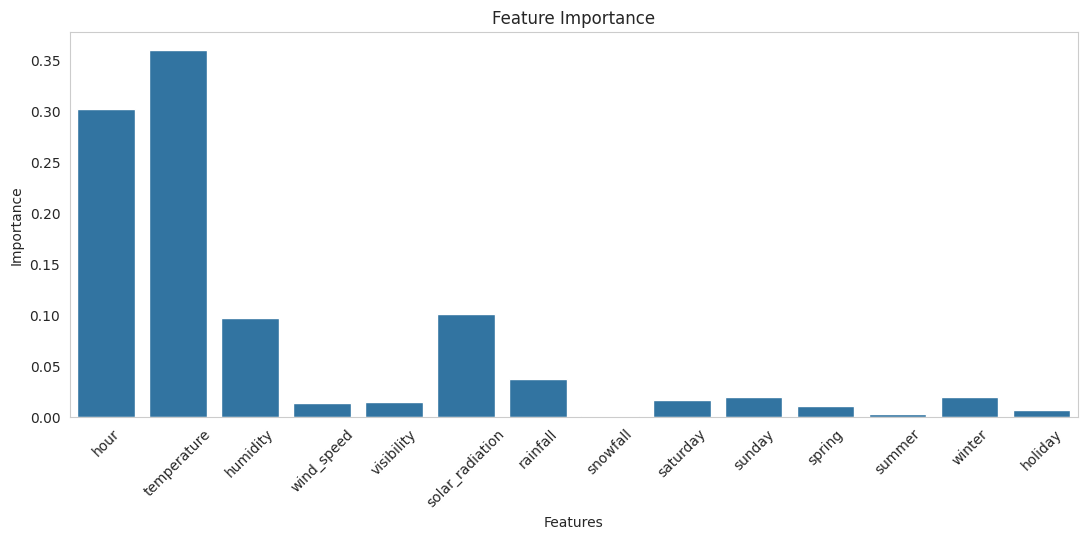

In [102]:
# Explore feature importance
rf_base_s.fit(X_train_s, y_train_s)
plt.figure(figsize=(13, 5))
feature = X_train_s.columns
feature_importances = rf_base_s.feature_importances_
sns.barplot(x=feature, y=feature_importances);
# Add labels to the plot, to the x-axis and y-axis
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)

#### Hyperopt

Let's try to select the optimal hyperparameters of the model

In [103]:
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'criterion': hp.choice('criterion', ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'])
}

def hyperopt_rf(params, cv=5, X=X_train_scaled_s, y=y_train_s):
    model = RandomForestRegressor(**params)
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()
    return -score

trials = Trials()
best = fmin(hyperopt_rf,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42)
           )

print(f"Best hyperparameter values: {best}")

100%|██████████| 100/100 [47:27<00:00, 28.48s/trial, best loss: -0.9163510544101868]
Best hyperparameter values: {'criterion': 0, 'max_depth': 11, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 59}


Best hyperparameter values: {'criterion': 0, 'max_depth': 11, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 59}

In [104]:
rf_best_s = RandomForestRegressor(
    random_state=42,
    n_estimators=int(best['n_estimators']),
    min_samples_leaf=1,
    max_depth=int(best['max_depth']),
    criterion=['poisson', 'squared_error', 'absolute_error', 'friedman_mse'][best['criterion']],
)

# Performing cross-validation and obtaining predictions for the training set
y_train_predict = model_selection.cross_val_predict(estimator=rf_best_s, X=X_train_scaled_s, y=y_train_s, cv=5)

# Performing cross-validation and obtaining predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=rf_best_s, X=X_test_scaled_s, y=y_test_s, cv=5)

# Calculating adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train_s, y_train_predict, X_train_scaled_s), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test_s, y_test_predict, X_test_scaled_s), 3)

# Calculating RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train_s, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test_s, y_test_predict)))

# Calculating the average model training time
# Performing cross-validation with timing the training process
scores = model_selection.cross_validate(rf_best_s, X_train_scaled_s, y_train_s, cv=5, scoring='r2', return_train_score=True)

# Calculating the average model training time
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 1.21 seconds
****************************************
Train Adjusted R2 (CV): 0.9
Test Adjusted R2 (CV): 0.866
****************************************
Train RMSE (CV): 204
Test RMSE (CV): 230


In [105]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['rf_best_s'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Training time': [fit_time_mean],
                        'Special model parameters':
                         ["random_state=42, criterion='poisson', 'max_depth': 11, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 59"]})

# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Model  Adjusted R2 RMSE  Training time  \
0            baseline_df        0.547  421           0.02   
1    baseline_df_grouped        0.577  407           0.04   
2          baseline_df_s        0.549  421           0.03   
3  baseline_df_grouped_s        0.578  407           0.02   
4                rf_base        0.861  233           3.63   
5                rf_best        0.866  230           2.67   
6              rf_base_s        0.864  231           2.49   
7              rf_best_s        0.866  230           1.21   

                            Special model parameters  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5  criterion='poisson', 'max_depth': 11, 'max_fea...  
6                                                NaN  
7  random_state=42, criterion='poisson', 'max_dep...

## GradientBoostingRegressor

In [ ]:
# X = df.drop('rented_bike_count', axis=1)
# y = df['rented_bike_count']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Hyperopt

In [108]:
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.9),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 11))
    }

def hyperopt_gb(params, cv=5, X=X_train_scaled_s, y=y_train_s):
    model = GradientBoostingRegressor(**params)
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()
    return -score

trials = Trials()
best = fmin(hyperopt_gb,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42)
           )

print(f"Best hyperparameter values: {best}")

100%|██████████| 100/100 [21:06<00:00, 12.67s/trial, best loss: -0.9333407383045363]
Best hyperparameter values: {'learning_rate': 0.06593426408591674, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 94}


Best hyperparameter values: {'learning_rate': 0.06593426408591674, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 94}

### Train

In [113]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


best_params = {
    'n_estimators': best['n_estimators'],
    'learning_rate': best['learning_rate'],
    'max_depth': best['max_depth'],
    'min_samples_split': best['min_samples_split']
}

gb = GradientBoostingRegressor(**best_params)

In [116]:
# Performing cross-validation and obtaining predictions for the training set
y_train_predict = model_selection.cross_val_predict(estimator=gb, X=X_train_scaled_s, y=y_train_s, cv=5)

# Performing cross-validation and obtaining predictions for the test set
y_test_predict = model_selection.cross_val_predict(estimator=gb, X=X_test, y=y_test, cv=5)

# Calculating adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train_s, y_train_predict, X_train_scaled_s), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test_s, y_test_predict, X_test), 3)

# Calculating RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train_s, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test_s, y_test_predict)))

# Performing cross-validation with timing the training process
scores = model_selection.cross_validate(gb, X_train_scaled_s, y_train_s, cv=5, scoring='r2', return_train_score=True)

# Calculating the average model training time
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 7.67 seconds
****************************************
Train Adjusted R2 (CV): 0.909
Test Adjusted R2 (CV): 0.868
****************************************
Train RMSE (CV): 194
Test RMSE (CV): 228


In [117]:
# Creating a temporary dataframe with data
temp_df = pd.DataFrame({'Model': ['gb'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Training time': [fit_time_mean],
                        'Special model parameters':
                         ["'learning_rate': 0.06593426408591674, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 94"]})

# Combining data using the concat method
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Model  Adjusted R2 RMSE  Training time  \
0            baseline_df        0.547  421           0.02   
1    baseline_df_grouped        0.577  407           0.04   
2          baseline_df_s        0.549  421           0.03   
3  baseline_df_grouped_s        0.578  407           0.02   
4                rf_base        0.861  233           3.63   
5                rf_best        0.866  230           2.67   
6              rf_base_s        0.864  231           2.49   
7              rf_best_s        0.866  230           1.21   
8                     gb        0.868  228           7.67   

                            Special model parameters  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5  criterion='poisson', 'max_depth': 11, 'max_fea...  
6                                                NaN  
7  random_state=42, criterion='poisson', 'max_dep...  
8  'learning_rate': 0.06593426408591674, 'max_dep...

### Test

In [119]:
# Checking the performance of gradient boosting on the training and test sets
# Fitting the model
gb.fit(X_train_scaled_s, y_train_s)

# Making predictions for the training set
gb_train = gb.predict(X_train_scaled_s)
# Making predictions for the test set
gb_pred = gb.predict(X_test_scaled_s)

# Calculating adjusted R2 for cross-validation
adjusted_r2_train = round(adjusted_r2_score(y_train_s, gb_train, X_train_scaled_s), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test_s, gb_pred, X_test_scaled_s), 3)

# Calculating RMSE for cross-validation
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train_s, gb_train)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test_s, gb_pred)))

# Performing cross-validation with timing the training process
scores = model_selection.cross_validate(gb, X_train_scaled_s, y_train_s, cv=5, scoring='r2', return_train_score=True)

# Calculating the average model training time
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 5.02 seconds
****************************************
Train Adjusted R2 (CV): 0.939
Test Adjusted R2 (CV): 0.898
****************************************
Train RMSE (CV): 160
Test RMSE (CV): 200


# Comparison of models

In [121]:
models_df.sort_values(by=['Adjusted R2', 'Training time'], ascending=[False, True])

Model  Adjusted R2 RMSE  Training time  \
8                     gb        0.868  228           7.67   
7              rf_best_s        0.866  230           1.21   
5                rf_best        0.866  230           2.67   
6              rf_base_s        0.864  231           2.49   
4                rf_base        0.861  233           3.63   
3  baseline_df_grouped_s        0.578  407           0.02   
1    baseline_df_grouped        0.577  407           0.04   
2          baseline_df_s        0.549  421           0.03   
0            baseline_df        0.547  421           0.02   

                            Special model parameters  
8  'learning_rate': 0.06593426408591674, 'max_dep...  
7  random_state=42, criterion='poisson', 'max_dep...  
5  criterion='poisson', 'max_depth': 11, 'max_fea...  
6                                                NaN  
4                                                NaN  
3                                                NaN  
1                                                NaN  
2                                                NaN  
0                                                NaN